In [2]:
devtools::install_github("WorldWeatherAttribution/rwwa")
suppressMessages(library("rwwa"))

Skipping install of 'rwwa' from a github remote, the SHA1 (9a841cf2) has not changed since last install.
  Use `force = TRUE` to force installation



# Revised functions for shift + scale

In [148]:
get.ns_pars <- function(fittype, pars, fixed_cov) {

  # support function only - better to use ns_pars with model

  if(missing(fittype)) {
    print("No fit type given")
    return()
  }

  if(missing(pars)) {
    print("No parameters given")
    return()
  }

  if(missing(fixed_cov)) {
    # set all covariates to zero
    fixed_cov <- setNames(data.frame(rep(0, sum(grepl("alpha", names(pars))))),
                          gsub("alpha_", "", names(pars)[(grepl("alpha", names(pars)))]))
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  # calculate effect of all alpha parameters
  effect_a <- rowSums(matrix(sapply(names(fixed_cov), function(cnm) pars[paste0("alpha_",cnm)] * fixed_cov[,cnm]), nrow = nrow(fixed_cov)))
  effect_b <- rowSums(matrix(sapply(names(fixed_cov), function(cnm) pars[paste0("beta_",cnm)] * fixed_cov[,cnm]), nrow = nrow(fixed_cov)))

  if(fittype == "fixeddisp") {

    ns_const = exp(effect_a / pars["mu0"])
    loc = pars["mu0"] * ns_const
    scale = pars["sigma0"] * ns_const

  } else if(fittype == "shift") {

    loc = pars["mu0"] + effect_a
    scale = rep(pars["sigma0"], length(loc))

  } else if(fittype == "shiftscale") {

    loc = pars["mu0"] + effect_a
    scale = exp(pars["sigma0"] + effect_b)

  } else {
    cat(fittype, "not implemented")
    return()
  }

  # return the list of named parameters: location, scale, shape (if applicable)
  if("shape" %in% names(pars)) {
    return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(scale))), unname))
  } else {
    return(lapply(list("loc" = loc, "scale" = scale), unname))
  }
}

####################################################################################################################
#' Get location, scale and (if relevant) shape of fitted nonstationary distribution at specified values of the covariates
#'
#' @param mdl list of parameters and attributes defining a fitted model, as returned by 'fit_ns'
#' @param fixed_cov data.frame containing values of the covariate at which the location is to be evaluated. Default value is NA, in which case nonstationary parameters are returned for all values of the covariate used to fit the model
#'
#' @return Return a list containing the location, scale and (if applicable) shape parameters corresponding to the given covariates
#'
#' @export
#'
ns_pars <- function(mdl, fixed_cov = NA) {

  # if no covariate value given, evaluate at all covariate values
  if(is.na(unlist(fixed_cov)[1])) fixed_cov <- mdl$cov

  # can either provide one covariate value per obs OR one fixed covariate
  if((nrow(fixed_cov) < length(mdl$x)) & (nrow(fixed_cov) > 1)) {
    print("Not implemented for multiple sets of fixed covariates: using first row of fixed_cov")
    fixed_cov <- fixed_cov[1,,drop = F]
  }

  # if fixed_cov contains extra covariates, drop them
  fixed_cov <- fixed_cov[,sapply(colnames(fixed_cov), function(cnm) cnm %in% mdl$covnm), drop = F]

  # if fixed_cov is missing any covariates, they will be assumed to be zero by support function
  if(!all(c(sapply(mdl$covnm, function(cnm) cnm %in% colnames(fixed_cov)), sapply(mdl$covnm, function(cnm) cnm %in% colnames(fixed_cov))))) {
    print("Not all model covariates appear in factual/counterfactual covariates: missing covariates will be assumed to be zero throughout")
  }

  # use support function to get parameters
  return(get.ns_pars(fittype = mdl$type, pars = mdl$par, fixed_cov = fixed_cov))
}

In [149]:
# ESTIMATE PARAMETERS OF NONSTATIONARY MODEL
#
# Methods to estimate the parameters of a nonstationary GEV or normal distribution using max-likelihood estimation
#
#' Support function to calculate the log-likelihood of a vector of data 'x' for a nonstationary distribution defined by the parameters 'pars' (used by 'fit_ns' to estimate the model parameters)
#'
#' @param pars Vector of named parameters of the nonstationary model
#' @param cov Data.frame containing values of the covariate(s) at which the location is to be evaluated
#' @param x Vector of data to evaluate log-likelihood
#' @param dist String defining the parametric form to be fitted (currently only implemented for 'gev' and 'norm')
#' @param fittype String defining the type of model fit to use - method is currently implemented for 'shift' and 'fixeddisp'
#'
#' @return Scalar log-likelihood
#'
#' @keywords internal
#' @export
#'
ns_loglik <- function(pars, cov, x, dist, fittype) {

  nspars <- get.ns_pars(fittype = fittype, pars = pars, fixed_cov = cov)

  loc <- nspars$loc
  scale <- nspars$scale
  shape <- nspars$shape

  # constrain variance to be strictly positive
  if(any(scale <= 0)) return(NA)

  # return negative log-likelihood
  if(dist == "norm") {
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
  } else if(dist == "gev") {
    shape = pars["shape"]
    return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
  } else {
    print(paste(dist, "not implemented"))
    return()
  }
}

################################################################################################################################
#' Use maximum likelihood estimation to find the parameters of the nonstationary model that best describes a vector of data 'x' using a set of given covariates
#'
#' @param dist String defining the parametric form to be fitted (currently only implemented for GEV and Gaussian)
#' @param type String defining the relationship between the fitted values and the covariate (currently implemented: 'shift' and 'fixeddisp')
#' @param data Data.frame with named columns containing the variable and any covariates of interest
#' @param varnm String identifying the dependent variable (must be a column name in 'data')
#' @param covnm String or vector of strings identifying the predictors (must be column names in 'data'). If not provided, a constant model will be fitted using a dummy covariate.
#' @param lower Boolean indicating whether to evaluate the lower tail of the data or not: default is F (evaluate the upper tail).
#' @param ev_year (optional) Scalar specifying the year of the event of interest; default is to use the value from the last row of 'data'
#' @param ev (optional) Scalar specifying the magnitude of the event of interest; default is to use the value corresponding to 'ev_year'
#' @param method String defining the method to be used by 'optim' to maximise the log-likelihood: default is 'BFGS'
#'
#' @return List of attributes & parameters defining a nonstationary model
#'
#' @details Further details to be added for dist & type
#'
#' @export
#'
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm = NA, lower = F, ev_year = NA, ev = NA, method = "BFGS") {

  # if no covariate name provided, add a dummy covariate & fit stationary series instead
  if(is.na(covnm[1])) {
    data <- cbind(data, "const" = 1)
    covnm <- "const"
  }

  # remove extraneous columns from dataframes
  cov <- data[, covnm, drop = F]
  k <- length(covnm)
  x <- data[,varnm]

  # should also add something to handle case with no covariates

  # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
  if(! dist %in% c("norm", "gev")) {
    print("Not yet implemented: use norm or gev")
    return()
  }

  # if looking at lower tail with a GEV, necessary to negate data and consider block maxima - add flag to keep track
  minima <- F
  if (lower & (dist %in% c("gev"))) {
      x <- -x
      minima <- T
  }

  # fit model with appropriate number of parameters, pad if necessary
  init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

  if(type %in% c("shiftscale")) init <- c(init, setNames(rep(0,k), paste0("beta_", covnm)))

  if(dist %in% c("gev")) init <- c(init, "shape" = 0)
  fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))

  # if looking at lower tail with a GEV, necessary to flip data and consider block maxima, so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
  if(minima) {
    fitted[["NOTE"]] <- "NB: model parameters are estimated for negated values"
    fitted$par["mu0"] <- -fitted$par["mu0"]
    fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
    x <- -x
  }

  # attach assorted useful information
  fitted[["dist"]] <- dist
  fitted[["type"]] <- type
  fitted[["varnm"]] <- varnm
  fitted[["covnm"]] <- covnm
  fitted[["data"]] <- data
  fitted[["x"]] <- x
  fitted[["cov"]] <- cov

  fitted[["lower"]] <- lower               # saves having to specify every time later on
  fitted[["minima"]] <- minima             # look at maxima of 0-temps, rather than minima of observed temps

  # event year: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev_year)) { ev_year <- data$year[length(x)] }
  fitted[["ev_year"]] <- ev_year
  fitted[["ev_idx"]] <- which(data$year == ev_year)

  # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
  if(is.na(ev)) {
    if(ev_year %in% data$year) {
        ev <- data[data$year == ev_year,varnm]
      } else {
        print("WARNING: Event year not in data, no event value recorded")
        ev <- -999
      }
    }
  fitted[["ev"]] <- ev

  return(fitted)
}


################################################################################################################################
#' Support function to refit the parameters of a model using new data (used in bootstrapping)
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param new_data Data.frame with named columns containing the variable and any covariates of interest: must contain the same covariates as the data used to fit 'mdl'
#'
#' @return List of attributes & parameters defining a nonstationary model
#'
#' @keywords internal
#'
#' @export
#'
refit <- function(mdl, new_data) {
  fit_ns(dist = mdl$dist, type = mdl$type, data = new_data, varnm = mdl$varnm, covnm = mdl$covnm, lower = mdl$lower, ev = mdl$ev)
}

################################################################################################################################
#' Calculate AIC from model output
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#'
#' @return AIC as scalar
#'
#' @export
#'
aic <- function(mdl) 2 * length(mdl$par) + 2 * mdl$value


################################################################################################################################
#' Calculate R^2 and adjusted R^2 from model output
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#'
#' @return Vector containing R^2 and adjusted R^2
#'
#' @export
#'
rsquared <- function(mdl) {

  tss = sum((mdl$x - mean(mdl$x))^2)
  rss = sum((ns_pars(mdl)$loc - mdl$x)^2)

  n = length(mdl$x)
  p = length(mdl$covnm)

  rsquared = 1 - (rss / tss)
  rsquared_adj = 1 - (1 - rsquared) * (n-1) / (n-p-1)

  return(c(r2 = rsquared, r2.adj = rsquared_adj))
}

In [150]:
# CHANGES IN LIKELIHOOD & INTENSITY
#
#' Support function to map a series of events x to exceedance probabilities under a given model
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param x Vector of event magnitudes to be transformed
#' @param fixed_cov data.frame containing values of the covariate to be used to transform the event magnitudes. Default value is NA, in which case nonstationary parameters are returned for all values of the covariate(s) used to fit the model
#'
#' @return Vector of exceedance probabilities
#'
#' @keywords internal
#'
#' @export
#'
map_to_u <- function(mdl, x, fixed_cov = NA) {

  pars <- ns_pars(mdl, fixed_cov = fixed_cov)
  if(missing(x)) x <- mdl$x

  # retrieve the actual fitted model parameters if they were negated for fitting (ie if looking at lower tails of GEV)
  if(mdl$minima) {
    pars$loc <- -pars$loc
    x = -x
    mdl$lower <- !mdl$lower # also have to look at the opposite tail
  }

  # get exceedance probability
  if(mdl$dist == "norm") {
    pit <- pnorm(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
  } else if(mdl$dist == "gev") {
    pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower))
  } else {
    return(NULL)
  }
  return(pit)
}


################################################################################################################################
#' Support function to map a series of exceedance probabilities u to event magnitudes x under a given model
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param u Vector of exceedance probabilities to be transformed
#' @param fixed_cov data.frame containing values of the covariate to be used to transform the probabilities. Default value is NA, in which case nonstationary parameters are returned for all values of the covariate(s) used to fit the model
#'
#' @return Vector of event magnitudes
#'
#' @keywords internal
#'
#' @export
#'
map_from_u <- function(mdl, u, fixed_cov = NA) {

  if(missing(u)) u <- map_to_u(mdl, fixed_cov = fixed_cov)
  pars <- ns_pars(mdl, fixed_cov = fixed_cov)

  # retrieve the actual fitted model parameters if they were flipped for fitting
  if(mdl$minima) {
    pars$loc <- -pars$loc
    mdl$lower <- !mdl$lower       # also have to look at the opposite tail
  }

  # map quantile onto stationary distribution
  if(mdl$dist == "norm") {
    # erl <- sapply(1:length(u), function(j) {
    #     qnorm(u[j], mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    # })
    erl <- qnorm(u, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
  } else if(mdl$dist == "gev") {
    erl <- sapply(1:length(u), function(j) {
      sapply(1:length(pars$loc), function(i) {
        qevd(u[j], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower)
      })
    })
  } else {
    return(NULL)
  }

  # if parameters flipped for fitting, flip 'em back
  if(mdl$minima) erl <- -erl

  return(erl)
}


################################################################################################################################
#' Transform one nonstationary distribution into another (or into a stationary distribution)
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param fixed_cov data.frame containing values of the covariate defining a stationary distribution
#'
#' @return Vector of event magnitudes corresponding to the stationary covariates
#'
#' @export
#'
stransform <- function(mdl, fixed_cov = NA) {

  # current default is to map NS distribution to itself - could give a stationary default instead
  map_from_u(mdl, u = map_to_u(mdl), fixed_cov = fixed_cov)
}


################################################################################################################################
#' Estimate the return period of an event or events for given covariates
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param x Vector of data to be transformed
#' @param fixed_cov data.frame containing values of the covariate at which the location is to be evaluated. Default value is NA, in which case nonstationary parameters are returned for all values of the covariate(s) used to fit the model
#'
#' @return Vector of return periods
#'
#' @export
#'
return_period <- function(mdl, x, fixed_cov = NA) {
  1 / map_to_u(mdl, x, fixed_cov)
}

################################################################################################################################
#' Estimate the probability ratio of an event under a given model: the factor-change in the probability of exceeding a set threshold when changing from the counterfactual to the factual world
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param ev Scalar: magnitude of event
#' @param cov_f Data.frame of covariate values defining the factual climate
#' @param cov_cf Data.frame of covariate values defining the counterfactual climate
#'
#' @return Scalar representing how much more or less likely it is that we will exceed the value 'ev' in the factual world vs the counterfactual world
#'
#' @export
#'
prob_ratio <- function(mdl, ev, cov_f, cov_cf) {

  if(missing(ev)) ev <- mdl$ev

  ep_f <- map_to_u(mdl, ev, fixed_cov = cov_f)
  ep_cf <- map_to_u(mdl, ev, fixed_cov = cov_cf)

  ep_f / ep_cf
}

################################################################################################################################
#' Estimate the effective return level of a fixed return period under a nonstationary model
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param rp Scalar indicating the return period of interest
#' @param fixed_cov data.frame containing values of the covariate at which the return level is to be evaluated. Default value is NA, in which case effective return levels are returned for all values of the covariate(s) used to fit the model
#'
#' @return Vector of effective return levels corresponding to the covariates provided
#'
#' @export
#'
eff_return_level <- function(mdl, rp, fixed_cov = NA) {

  map_from_u(mdl, 1/rp, fixed_cov = fixed_cov)
}


################################################################################################################################
#' Estimate the change in intensity of events of a specified return period under a given model, between the counterfactual and factual worlds
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param rp Scalar: return period of interest
#' @param cov_f Data.frame of covariate values defining the factual climate
#' @param cov_cf Data.frame of covariate values defining the counterfactual climate
#' @param relative Boolean: return change as relative (F) or absolute (T)? Default is F
#'
#' @return Scalar representing the estimated change in intensity
#'
#' @export
#'
int_change <- function(mdl, rp = NA, cov_f, cov_cf, relative = F) {

  if(is.na(rp)) {
    if(relative) {
      cat("Return period needed to calculate relative change")
      return(NA)
    } else {
      rp <- 10
    }
  }
  # if return period is less than 1, assume it's an exceedance probability and convert to a return period
  if(rp < 1) { rp <- 1/rp } else { rp <- rp }

  # get effective return levels
  rl <- eff_return_level(mdl, rp, fixed_cov = cov_f)
  rl_cf <- eff_return_level(mdl, rp, fixed_cov = cov_cf)

  # if variable is logged, convert to real values first
  if(substr(mdl$varnm, 1, 5) == "log10") {
    rl <- 10^rl
    rl_cf <- 10^rl_cf
  } else if (substr(mdl$varnm, 1, 3) == "log"){
    rl <- exp(rl)
    rl_cf <- exp(rl_cf)
  }

  if(relative) {
    (rl - rl_cf) / rl_cf * 100
  } else {
    rl - rl_cf
  }
}

In [151]:
# SUMMARISE MODEL RESULTS
#
#' Get best estimates of parameters from fitted model
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param cov_f Data.frame with one row containing named covariates defining the factual climate
#' @param cov_cf Data.frame with one or more rows containing named covariates defining the counterfactual climate
#' @param ev (Optional) scalar: magnitude of the event of interest. If not provided, event value is picked up from the fitted model
#' @param rp (Optional) scalar: fixed return period of interest
#'
#' @return Vector containing estimates of all model parameters and quantities of interest
#'
#' @export
#'
mdl_ests <- function(mdl, cov_f, cov_cf, ev, rp = NA) {

  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }

  if(!all(c(sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_f)), sapply(mdl$covnm, function(cnm) cnm %in% colnames(cov_cf))))) {
    print("Not all model covariates appear in factual/counterfactual covariates: missing covariates will be assumed to be zero throughout")
  }

  pars <- mdl$par
  current_pars <- ns_pars(mdl, fixed_cov = cov_f)
  disp <- current_pars$scale / current_pars$loc

  if(is.na(rp)) {
    # if no fixed RP is given, estimate it from the event value
    if(missing(ev)) ev <- mdl$ev
    rp <- return_period(mdl, ev, fixed_cov = cov_f)
  } else {
    # if fixed RP given, use it to bootstrap the expected magnitude of the event value
    ev <- eff_return_level(mdl, rp, fixed_cov = cov_f)
  }

  # loop over counterfactual covariates (if necessary) & get PRs and intensity changes
  if(nrow(cov_cf) == 1) {
      changes <- c("PR" = prob_ratio(mdl, ev, cov_f, cov_cf),
                   "dI_abs" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = F), error = function(cond) {return(NA)}),
                   "dI_rel" = tryCatch(int_change(mdl, rp, cov_f, cov_cf, relative = T), error = function(cond) {return(NA)}))
  } else {
      changes <- unlist(lapply(rownames(cov_cf), function(rnm) {
          pr <- prob_ratio(mdl, ev, cov_f, cov_cf[rnm,,drop = F])
          di_abs <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = F), error = function(cond) {return(NA)})
          di_rel <- tryCatch(int_change(mdl, rp, cov_f, cov_cf[rnm,,drop = F], relative = T), error = function(cond) {return(NA)})
          setNames(c(pr, di_abs, di_rel), paste0(c("PR", "dI_abs", "dI_rel"), "_",rnm))
      }))
  }

  return(c(mdl$par, "disp" = disp, "event_magnitude" = ev, "return_period" = rp, changes))
}


################################################################################################################################
#' Bootstrapped confidence intervals of parameter estimates for a fitted model
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param cov_f Data.frame with one row containing named covariates defining the factual climate
#' @param cov_cf Data.frame with one or more rows containing named covariates defining the counterfactual climate
#' @param ev (Optional) scalar: magnitude of the event of interest. If not provided, event value is picked up from the fitted model
#' @param rp (Optional) scalar: fixed return period of interest
#' @param seed Scalar: seed to be used to initialise random sample for bootstrapped confidence intervals (if using)
#' @param nsamp Scalar: number of bootstrap samples to be used to estimate confidence intervals for location parameter. Set to NA if no confidence intervals are required. Default is 500.
#' @param ci Scalar from 0 to 1 defining width of confidence interval. Default is 0.95
#' @param return_sample Boolean: return confidence interval (F) or full bootstrap sample (T)? Default is to return the interval (F).
#'
#' @return Data.frame containing estimates of all model parameters and quantities of interest, along with limits of central confidence interval; or matrix of bootstrapped values of each quantity (can be useful if 95% interval is unstable)
#'
#' @export
#'
boot_ci <- function(mdl, cov_f, cov_cf, ev, rp = NA, seed = 42, nsamp = 500, ci = 0.95, return_sample = F) {

  alpha <- 1-ci

  # if event value not provided, get stored value from fitted model
  if(missing(ev)) ev <- mdl$ev

  # remove any extraneous variables from covariate tables
  cov_f <- cov_f[,mdl$covnm, drop = F]
  cov_cf <- cov_cf[,mdl$covnm, drop = F]

  # trim factual covariates if necessary
  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }

  # if any covariates not provided, replace with 0 (otherwise will print error message for every bootstrap sample)
  for (cnm in mdl$covnm) {
    if(!cnm %in% colnames(cov_f)) {
      cat(cnm,"missing from factual covariates: assumed to be zero\n\n")
      cols_f <- colnames(cov_f)
      cov_f <- cbind(cov_f, 0)
      colnames(cov_f) <- c(cols_f, cnm)
    }
    if(!cnm %in% colnames(cov_cf)) {
      cat(cnm,"missing from counterfactual covariates: assumed to be zero\n\n")
      cols_cf <- colnames(cov_cf)
      cov_cf <- cbind(cov_cf, 0)
      colnames(cov_cf) <- c(cols_cf, cnm)
    }
  }

  obs_res <- mdl_ests(mdl, cov_f, cov_cf, ev, rp = rp)

  # get bootstrap sample
  set.seed(seed)
  boot_res <- sapply(1:nsamp, function(i) {
    boot_df <- mdl$data[sample(1:nrow(mdl$data), replace = T),]
    tryCatch({
      boot_mdl <- refit(mdl, new_data = boot_df)
      mdl_ests(boot_mdl, cov_f, cov_cf, ev = ev, rp = rp)
    },
    error = function(cond) {return(rep(NA, length(obs_res)))})
  })
  if(return_sample) {
    return(boot_res)
  } else {
    boot_qq <- t(rbind("est" = obs_res, apply(boot_res, 1, quantile, c(alpha/2, 1-(alpha/2)), na.rm = T)))
    return(boot_qq)
  }
}


################################################################################################################################
#' Bootstrapped confidence intervals of parameter estimates for a fitted model, tailored to WWA requirements for evaluation, attribution and projection of results from climate models
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param rp Scalar: fixed return period of interest
#' @param cov_f Data.frame with one row containing named covariates defining the factual climate
#' @param cov_hist Data.frame with one or more rows containing named covariates defining the historic counterfactual climate
#' @param cov_fut (optional) Data.frame with one or more rows containing named covariates defining the future counterfactual climate
#' @param y_start Integer: first year for which observations are available, used to determine the start of the evaluation period. Default is 1979.
#' @param y_now Integer: last year for which observations are available, used to determine the start of the evaluation/attribution period. Default is to use the current year.
#' @param y_fut Integer: last year to be used in the projection model. Default is 2050.
#' @param seed Scalar: seed to be used to initialise random sample for bootstrapped confidence intervals (if using)
#' @param nsamp Scalar: number of bootstrap samples to be used to estimate confidence intervals for location parameter. Set to NA if no confidence intervals are required. Default is 500.
#' @param ci Scalar from 0 to 1 defining width of confidence interval. Default is 0.95
#' @param return_sample Boolean: return confidence interval (F) or full bootstrap sample (T)? Default is to return the interval (F).
#' @param di_relative Boolean: force the return of relative (F) or absolute (T) change in intensity. Default is to choose based on fit type (shift = absolute, fixeddisp = relative)
#'
#' @return Data.frame containing estimates of all model parameters and quantities of interest, along with limits of central confidence interval; or matrix of bootstrapped values of each quantity (can be useful if 95% interval is unstable)
#'
#' @export
#'
cmodel_results <- function(mdl, rp = 10, cov_f, cov_hist, cov_fut,
                           y_start = 1979, y_now = as.integer(substr(Sys.Date(),1,4)), y_fut = 2050,
                           nsamp = 5, seed = 42, ci = 0.95, return_sample = F, di_relative = NA) {

  alpha <- 1-ci
  set.seed(seed)

  # fill in missing parameters
  if(is.na(di_relative)) di_relative <- mdl$type == "fixeddisp"

  # remove any extraneous variables from covariate tables
  cov_f <- cov_f[,mdl$covnm, drop = F]
  cov_hist <- cov_hist[,mdl$covnm, drop = F]

  # trim factual covariates if necessary
  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # update model for evaluation & attribution

  df <- mdl$data

  # fit models to subsets of the data
  mdl_eval <- refit(mdl, new_data = df[df$year >= y_start & df$year <= y_now,])
  mdl_attr <- refit(mdl, new_data = df[df$year <= y_now,])

  # get return level to use for analysis
  event_rl <- eff_return_level(mdl_attr, rp = rp, fixed_cov = cov_f)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  ## Bootstrap each set of model results

  if(mdl$type == "fixeddisp") { key_par <- "disp" } else { key_par <- "sigma0" }
  if(mdl$dist == "gev") { key_par <- c(key_par, "shape") }
  if(di_relative) { di_cnm <- "dI_rel" } else { di_cnm <- "dI_abs" }

  # get bootstrapped intervals, select only the elements of interest
  ci_eval <- boot_ci(mdl_eval, cov_f = cov_f, cov_cf = cov_hist, ev = event_rl, rp = rp, nsamp = nsamp)[key_par,,drop = F]
  ci_attr <- boot_ci(mdl_attr, cov_f = cov_f, cov_cf = cov_hist, ev = event_rl, rp = rp, nsamp = nsamp)
  ci_attr <- ci_attr[grepl(paste0("PR|",di_cnm), rownames(ci_attr)),]

  # flatten & rename
  ci_eval <- unlist(lapply(rownames(ci_eval), function(cnm) setNames(ci_eval[cnm,], paste("eval", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
  ci_attr <- unlist(lapply(rownames(ci_attr), function(cnm) setNames(ci_attr[cnm,], paste("attr", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))

  # compile results so far
  res <- c(ci_eval, "rp_value" = event_rl, ci_attr)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # bootstrap model results (if future covariates given)
  if(!missing(cov_fut)) {

    # drop any extraneous covariates
    cov_fut <- cov_fut[,mdl$covnm, drop = F]

    # refit the model
    mdl_proj <- refit(mdl, new_data = df[df$year <= y_fut,])

    # bootstrap results
    ci_proj <- boot_ci(mdl_proj, cov_f = cov_f, cov_cf = cov_fut, ev = event_rl, rp = rp, nsamp = nsamp)
    ci_proj <- ci_proj[grepl(paste0("PR|",di_cnm), rownames(ci_proj)),]

    # invert future projections
    ci_proj[grepl("PR", rownames(ci_proj)),] <- 1/ci_proj[grepl("PR", rownames(ci_proj)),c(1,3,2)]
    ci_proj[grepl(di_cnm, rownames(ci_proj)),] <- -ci_proj[grepl(di_cnm, rownames(ci_proj)), c(1,3,2)]

    ci_proj <- unlist(lapply(rownames(ci_proj), function(cnm) setNames(ci_proj[cnm,], paste("proj", gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))

    res <- c(res, ci_proj)
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  # reshape & relabel results
  res <- t(data.frame(res))
  rownames(res) <- paste0(mdl$varnm, " ~ ", paste(mdl$covnm, collapse = " + "), " (rp", rp,")")
  return(res)
}

In [152]:
# PLOTTING FUNCTIONS
#
#' Plot a fitted trend over time
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param ev (Optional) scalar: magnitude of the event of interest. If not provided, event value is picked up from the fitted model
#' @param ev_year (Optional) scalar: year of the event of interest. If not provided, inferred from the fitted model
#' @param rp (Optional) vector of length two, setting return period for which effective return levels should be plotted. Default is c(6,40)
#' @param add_loess Boolean: add a Loess smoother to the plot? Default is F.
#' @param loess_col String: set colour to be used for Loess smoother (if using). Default is 'forestgreen'.
#' @param xlab (Optional) string: label for x axis: default is 'Year'
#' @param ylab (Optional) string: label for y axis: default is to use variable name
#' @param legend_pos String indicating location of legend: default is 'topleft'. Change to NA to remove legend.
#' @param main String: main title for plot. Default is to leave blank.
#' @param xlim (Optional) vector defining the limits of the x axis
#' @param ylim (Optional) vector defining the lower and upper limits of the y axis
#' @param lwd Scalar: line weight to be used in plotting
#'
#' @export
#'
plot_trend <- function(mdl, ev, ev_year, rp = c(6, 40), add_loess = F, loess_col = "forestgreen",
                       xlab = "Year", ylab = NA, legend_pos = "topleft", main = "", xlim = NA, ylim = NA, lwd = 2) {

  if(is.na(ylab)) {ylab <- mdl$varnm}
  if(is.na(unlist(xlim)[1])) { xlim <- range(mdl$data$year) }
  if(is.na(unlist(ylim)[1])) { ylim <- range(pretty(mdl$x)) }
  if(missing(ev)) { ev <- mdl$ev }
  if(missing(ev_year)) { ev_year <- mdl$data$year[which.min(abs(mdl$x - ev))] }

  # set up legend
  legend_labels = "Fitted value"
  legend_cols = "black"
  legend_lty = "solid"
  legend_lwd = lwd

  # modify legend if adding effective return levels
  rp <- unique(rp[!is.na(rp)])
  if(length(rp) > 0) {
    legend_labels = c(legend_labels, paste0("1-in-",rp,"-year event"))
    legend_cols = c(legend_cols, rep("blue",length(rp)))
    legend_lty = c(legend_lty, rep("solid",length(rp)))
    legend_lwd = c(legend_lwd,c(lwd,max(1,lwd -1))[1:length(rp)])
  }

  plot(mdl$data$year, mdl$x, type = "S", lwd = lwd, col = adjustcolor("black", 0.5), xlab = xlab,
       ylab = ylab, main = main, xlim = xlim, ylim = ylim)

  lines(mdl$data$year-0.5, ns_pars(mdl)$loc, col = adjustcolor("black", 1), lwd = lwd)
  lines(mdl$data$year-0.5, eff_return_level(mdl, rp[1]), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = lwd)
  lines(mdl$data$year-0.5, eff_return_level(mdl, rp[2]), type = "l", lty = 1, col = adjustcolor("blue", 1), lwd = max(1,lwd -1))

  # add a loess smoother
  if(add_loess) {
    lines(mdl$data$year, fitted(loess(formula(paste0(mdl$varnm," ~ year")), mdl$data)), col = loess_col, lwd = lwd, lty = "22")
    legend_labels <- c(legend_labels, "Loess smoothed")
    legend_cols <- c(legend_cols, loess_col)
    legend_lty <- c(legend_lty, "22")
    legend_lwd <- c(legend_lwd, lwd)
  }

  points(ev_year-0.5, ev, col = "magenta", lwd = 2, pch = 0)

  # add legend
  legend(legend_pos, legend = legend_labels, lty = legend_lty, col = legend_cols, lwd = legend_lwd)
}


################################################################################################################################
#' Plot fitted trend against a single covariate
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param xcov String indicating the covariate to plot on the x-axis. Must appear in mdl$cov.
#' @param trend_cov Data.frame containing values of the covariates to be used to plot the trend. Default value is NA, in which case the trend is estimated at all values of xcov with all other covariates held at their mean value
#' @param ci_cov (Optional) Data.frame containing values of the covariates at which confidence intervals for the location parameter should be estimated. Default is NA, in which case no confidence bounds are plotted.
#' @param ci_col String: set colour to be used for confidence bounds (if using). Default is 'black'.
#' @param ev (Optional) scalar: magnitude of the event of interest. If not provided, event value is picked up from the fitted model
#' @param ev_x (Optional) scalar: x-value against which to plot the event of interest. If not provided, event year is picked up from the fitted model
#' @param rp (Optional) vector of length two, setting return period for which effective return levels should be plotted. Default is c(6,40)
#' @param add_loess Boolean: add a Loess smoother to the plot? Default is F.
#' @param loess_col String: set colour to be used for Loess smoother (if using). Default is 'forestgreen'.
#' @param seed Scalar: seed to be used to initialise random sample for bootstrapped confidence intervals (if using)
#' @param nsamp Scalar: number of bootstrap samples to be used to estimate confidence intervals for location parameter. Set to NA if no confidence intervals are required. Default is 500.
#' @param xlim (Optional) vector defining the left and right limits of the x axes
#' @param ylim (Optional) vector defining the lower and upper limits of the y axes
#' @param xlab (Optional) string: label for x axis. Default is to use 'xcov'
#' @param ylab (Optional) string: label for y axis. Default is to leave blank.
#' @param legend_pos String indicating location of legend: default is 'topleft'. Change to NA to remove legend.
#' @param main String: main title for plot. Default is to leave blank.
#' @param lwd Scalar: line weight to be used in plotting. Default is 3
#'
#' @export
#'
plot_covtrend <- function(mdl, xcov, trend_cov = NA, ci_cov = NA,  ci_col = "black", ev, ev_x, rp = c(6,40), add_loess = F, loess_col = "forestgreen",
                          seed = 42, nsamp = 500, xlim = NA, ylim = NA, xlab = NA, ylab = NA, legend_pos = "topleft", main = "", lwd = 3) {

  if(is.na(xlab)) { xlab <- toupper(xcov)}
  if(is.na(ylab)) { ylab <- mdl$varnm}
  if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
  if(missing(ev)) { ev <- mdl$ev }

  x <- mdl$data[,xcov]
  if(missing(ev))    { ev <- mdl$ev }
  if(missing(ev_x)) {ev_x <- x[which(mdl$x == ev)]}
  o <- order(x)

  if(is.na(unlist(ci_cov)[1])) {
    # can't plot confidence intervals so set nsamp to NA
    nsamp <- NA
    xlims <- range(x)
  } else {
    # extend the x-axis to accommodate the CI covariates
    xlims <- range(pretty(c(ci_cov[,xcov], x)))

    # if only the x-covariate is provided, set the other covariates to the mean value for plotting
    for(cnm in mdl$covnm) {
      if(!cnm %in% colnames(ci_cov)) ci_cov[,cnm] <- mean(mdl$data[,cnm])
    }
  }
  if(is.na(unlist(xlim)[1])) xlim <- xlims

  if(is.na(unlist(trend_cov)[1])) {
    # if no plotting covariate provided, fix all covariates at mean value except for xcov
    trend_cov <- data.frame(sapply(mdl$covnm, function(cnm) if(cnm == xcov) {mdl$data[,cnm]} else {mean(mdl$data[,cnm])}, simplify = F))
  }

  # set up legend
  legend_labels = "Fitted value"
  legend_cols = "black"
  legend_lty = "solid"
  legend_lwd = lwd

  # modify legend if adding effective return levels
  rp <- unique(rp[!is.na(rp)])
  if(length(rp) > 0) {
    legend_labels = c(legend_labels, paste0("1-in-",rp,"-year event"))
    legend_cols = c(legend_cols, rep("blue",length(rp)))
    legend_lty = c(legend_lty, rep("solid",length(rp)))
    legend_lwd = c(legend_lwd,c(lwd,max(1,lwd -1))[1:length(rp)])
  }

  plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = xlim,
       col = adjustcolor("black", 0.6))
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))

  points(ev_x, ev, col = "magenta", lwd = 2, pch = 0)

  # trend lines
  lines(x[o], ns_pars(mdl, fixed_cov = trend_cov)$loc[o], lwd = 3, col = "black", lty = 1)
  lines(x[o], eff_return_level(mdl, rp[1], fixed_cov = trend_cov)[o], col = "blue", lwd = 3, lty = 1)
  lines(x[o], eff_return_level(mdl, rp[2], fixed_cov = trend_cov)[o], col = "blue", lwd = 2, lty = 1)

  # get confidence interval for mu' (if not required, set ci_cov to NA)
  if(!is.na(nsamp)) {
    mdl_df <- mdl$data
    set.seed(seed)
    mu_ci <- apply(sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        sapply(rownames(ci_cov), function(rnm) ns_pars(boot_mdl, ci_cov[rnm,,drop = F])$loc)
      }, error = function(cond) {return(rep(NA, nrow(ci_cov)))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)

    # confidence interval & markers for mu' at factual & counterfactual covariates
    segments(x0 = ci_cov[,xcov], y0 = mu_ci["2.5%",], y1 = mu_ci["97.5%",], lwd = 3, col = ci_col, lend = 1)
    # matplot(ci_cov[,"gmst"], t(mu_ci), pch = 3, add = T, col = "red3") # line ends: not very elegant, so removed for now
    points(ci_cov[,xcov], sapply(rownames(ci_cov), function(rnm) ns_pars(mdl, ci_cov[rnm,,drop = F])$loc), pch = "_", col = ci_col, lwd = 2)
  }

  # add a loess smoother
  if(add_loess) {
    dfx <- mdl$data[order(mdl$data[,xcov]),]
    lines(dfx[,xcov], fitted(loess(formula(paste0(mdl$varnm," ~ ", xcov)), dfx)), col = loess_col, lwd = lwd, lty = "22")
    legend_labels <- c(legend_labels, "Loess smoothed")
    legend_cols <- c(legend_cols, loess_col)
    legend_lty <- c(legend_lty, "22")
    legend_lwd <- c(legend_lwd, lwd)
  }

  # add legend
  legend(legend_pos, legend = legend_labels, lty = legend_lty, col = legend_cols, lwd = legend_lwd, cex = par()$cex.lab)
}


################################################################################################################################
#' Goodness-of-fit plot comparing return levels in factual and counterfactual climates
#'
#' @param mdl List of attributes & parameters defining a nonstationary model, as returned by 'fit_ns'
#' @param cov_f Data.frame with one row containing named covariates defining the factual climate
#' @param cov_cf Data.frame with one row containing named covariates defining the counterfactual climate
#' @param ev (Optional) scalar: magnitude of the event of interest. If not provided, event value is picked up from the fitted model
#' @param seed Scalar: seed to be used to initialise random sample for bootstrapped confidence intervals (if using)
#' @param nsamp Scalar: number of bootstrap samples to be used to estimate confidence intervals for location parameter. Set to NA if no confidence intervals are required. Default is 500.
#' @param model_desc Boolean: add description of model to plot? Default is T.
#' @param xlim Vector defining the lower and upper limits of the x axes (default is c(1,10000))
#' @param ylim (Optional) vector defining the lower and upper limits of the y axes
#' @param pch Scalar determing the plotting character to be used. Default is 20.
#' @param xlab (Optional) string: label for x axis. Default is "Return period (years)".
#' @param ylab (Optional) string: label for y axis. Default is to use the covariate name.
#' @param main String: main title for plot. Default is to leave blank.
#' @param legend_pos String indicating location of legend: default is 'topleft'. Change to NA to remove legend.
#' @param legend_labels Vector of labels for legend: default is c("Present climate", "Counterfactual climate").
#'
#' @export
#'
plot_returnlevels <- function(mdl, cov_f, cov_cf, ev, seed = 42, nsamp = 500, model_desc = T,
                              xlim = c(1,10000), ylim = NA, pch = 20, xlab = "Return period (years)", ylab = NA, main = "",
                              legend_pos = "topright", legend_labels = c("Present climate", "Counterfactual climate")) {

  x <- mdl$x
  if(missing(ev)) { ev <- mdl$ev }

  rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
  rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

  # trim covariates if necessary
  if(nrow(cov_f) > 1) {
    print("cov_f has more than one row: only first row will be used as factual covariates")
    cov_f <- cov_f[1,,drop = F]
  }
  # trim covariates if necessary
  if(nrow(cov_cf) > 1) {
    print("cov_cf has more than one row: only first row will be used as counterfactual covariates")
    cov_cf <- cov_cf[1,,drop = F]
  }

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # calculate return periods & return levels

  rl_curve_pres <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_f)
  rl_curve_cf <- map_from_u(mdl, 1/rp_x, fixed_cov = cov_cf)

  rl_obs_pres <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_f)
  rl_obs_cf <- map_from_u(mdl, map_to_u(mdl), fixed_cov = cov_cf)

  rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov_f)
  rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # prep axes

  if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
  if(is.na(ylab)) {ylab <- mdl$varnm}

  # plot
  plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
  mtext(xlab, side = 1, line = 2.5, cex = par("cex.lab"))
  mtext(ylab, side = 2, line = 2.5, cex = par("cex.lab"))

  # if model description is required, add it as legend title
  if(model_desc) {
    legend_title <- paste0(mdl$varnm, " ~ ", paste0(mdl$covnm, collapse = " + "), " (",mdl$dist, ", ", mdl$type, ")")
  } else {
    legend_title <- ""
  }

  # add legend
  legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA),
         bty = "n", cex = par()$cex.lab, title = legend_title)

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  # return period curves
  lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
  lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual

  # expected return periods vs return levels transformed to stationarity at that covariate value
  points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
  points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual

  # horizontal line showing observed event, plus ticks showing return periods
  abline(h = ev, col = "magenta", lty = 2)
  suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
  suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  # Add confidence intervals to return periods

  if(!is.na(nsamp)) {
    x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
    set.seed(seed)

    mdl_df <- mdl$data[,c(mdl$varnm, mdl$covnm)]
    boot_res <- sapply(1:nsamp, function(i) {
      boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
      tryCatch({
        boot_mdl <- refit(mdl, boot_df)
        # print(boot_mdl$par)
        c(map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_f), map_from_u(boot_mdl, 1/x_ci, fixed_cov = cov_cf))
      }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
    })
    est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)

    # shaded region for confidence intervals
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", 0.1))
    polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", 0.1))
  }
}

# FWI

## FWI1x

In [49]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2025 Jan FWI should all be labelled as 2025
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))

# load data
df <- merge(merge(gmst, nino), read.csv("ts/era5_fwi1x-jan_socal-baja.csv"))

# get factual & counterfactual covariates
cov_2025 = df[df$year == 2025, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2025 - c(1.3, 0),
               "neut" = c(cov_2025$gmst, 0),
               "pineut" = c(-1.3, 0))

# fit chosen model
mdl_fwi1x <- fit_ns("gev", "shift", df, varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F)

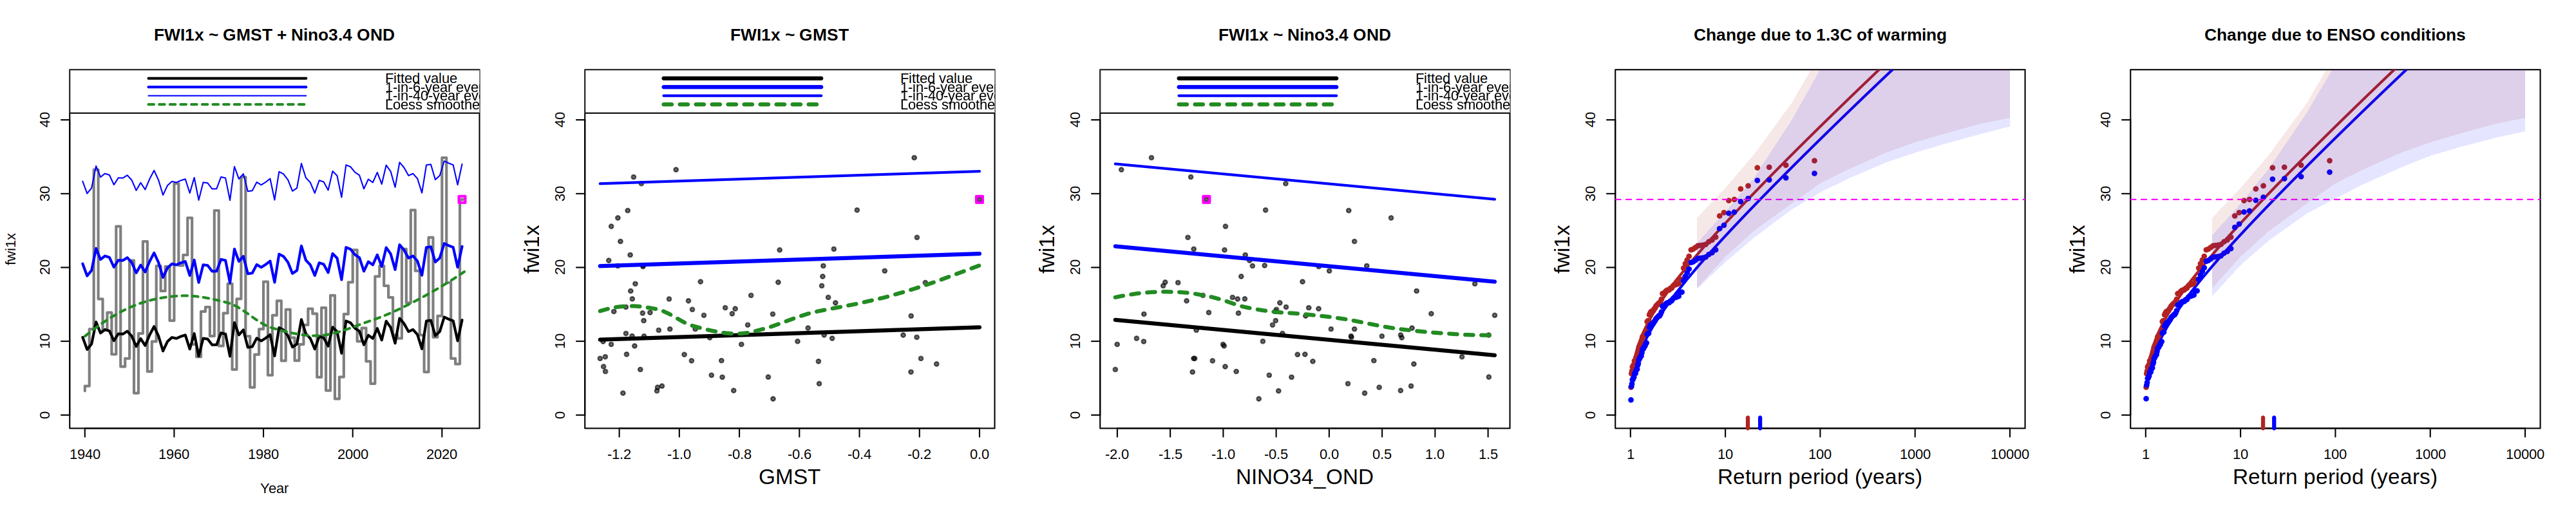

In [50]:
prep_window(c(1,5))
ylim = c(0,45)

plot_trend(mdl_fwi1x, add_loess = T, main = "FWI1x ~ GMST + Nino3.4 OND", ylim = ylim)
plot_covtrend(mdl_fwi1x, xcov = "gmst", add_loess = T, main = "FWI1x ~ GMST", ylim = ylim)
plot_covtrend(mdl_fwi1x, xcov = "nino34_ond", add_loess = T, main = "FWI1x ~ Nino3.4 OND", ylim = ylim)

plot_returnlevels(mdl_fwi1x, cov_f = cov_2025, cov_cf = cov_cf["pi",,drop=F], main = "Change due to 1.3C of warming", ylim = ylim)
plot_returnlevels(mdl_fwi1x, cov_f = cov_2025, cov_cf = cov_cf["neut",,drop=F], main = "Change due to ENSO conditions", ylim = ylim)

In [51]:
boot_res <- boot_ci(mdl_fwi1x, cov_f = cov_2025, cov_cf = cov_cf)
write.csv(boot_res, "res/res-obs_fwi1x_era5.csv")

In [55]:
6.261 + 5.608

[1] 11.869

In [52]:
round(boot_res, 3)

,est,2.5%,97.5%
mu0,11.320,7.774,15.725
sigma0,5.954,4.841,6.969
alpha_gmst,1.324,-2.721,5.745
alpha_nino34_ond,-1.339,-2.901,-0.273
shape,-0.019,-0.179,0.175
disp,0.463,0.321,0.654
event_magnitude,29.212,29.212,29.212
return_period,17.266,7.713,56.480
PR_pi,1.347,0.440,4.768
dI_abs_pi,1.721,-3.537,7.469


## Model selection

### Choice of accumulation

In [124]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2025 Jan FWI should all be labelled as 2025
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
df$gmst <- df$gmst - df$gmst[df$year == 2025]

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))

In [125]:
df <- merge(merge(merge(merge(merge(gmst, nino), 
                  read.csv("ts/era5_fwi1x-jan_socal-baja.csv")), read.csv("ts/era5_fwi3x-jan_socal-baja.csv")), read.csv("ts/era5_fwi5x-jan_socal-baja.csv")), read.csv("ts/era5_fwi7x-jan_socal-baja.csv"))
df <- df[df$year >= 1960,]

cov_2025 = df[df$year == 2025, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2025 - c(1.3, 0),
               "neut" = c(cov_2025$gmst, 0),
               "1960s" = c(mean(df[(df$year >= 1960) & (df$year < 1970),"gmst"]), cov_2025$nino34_ond))

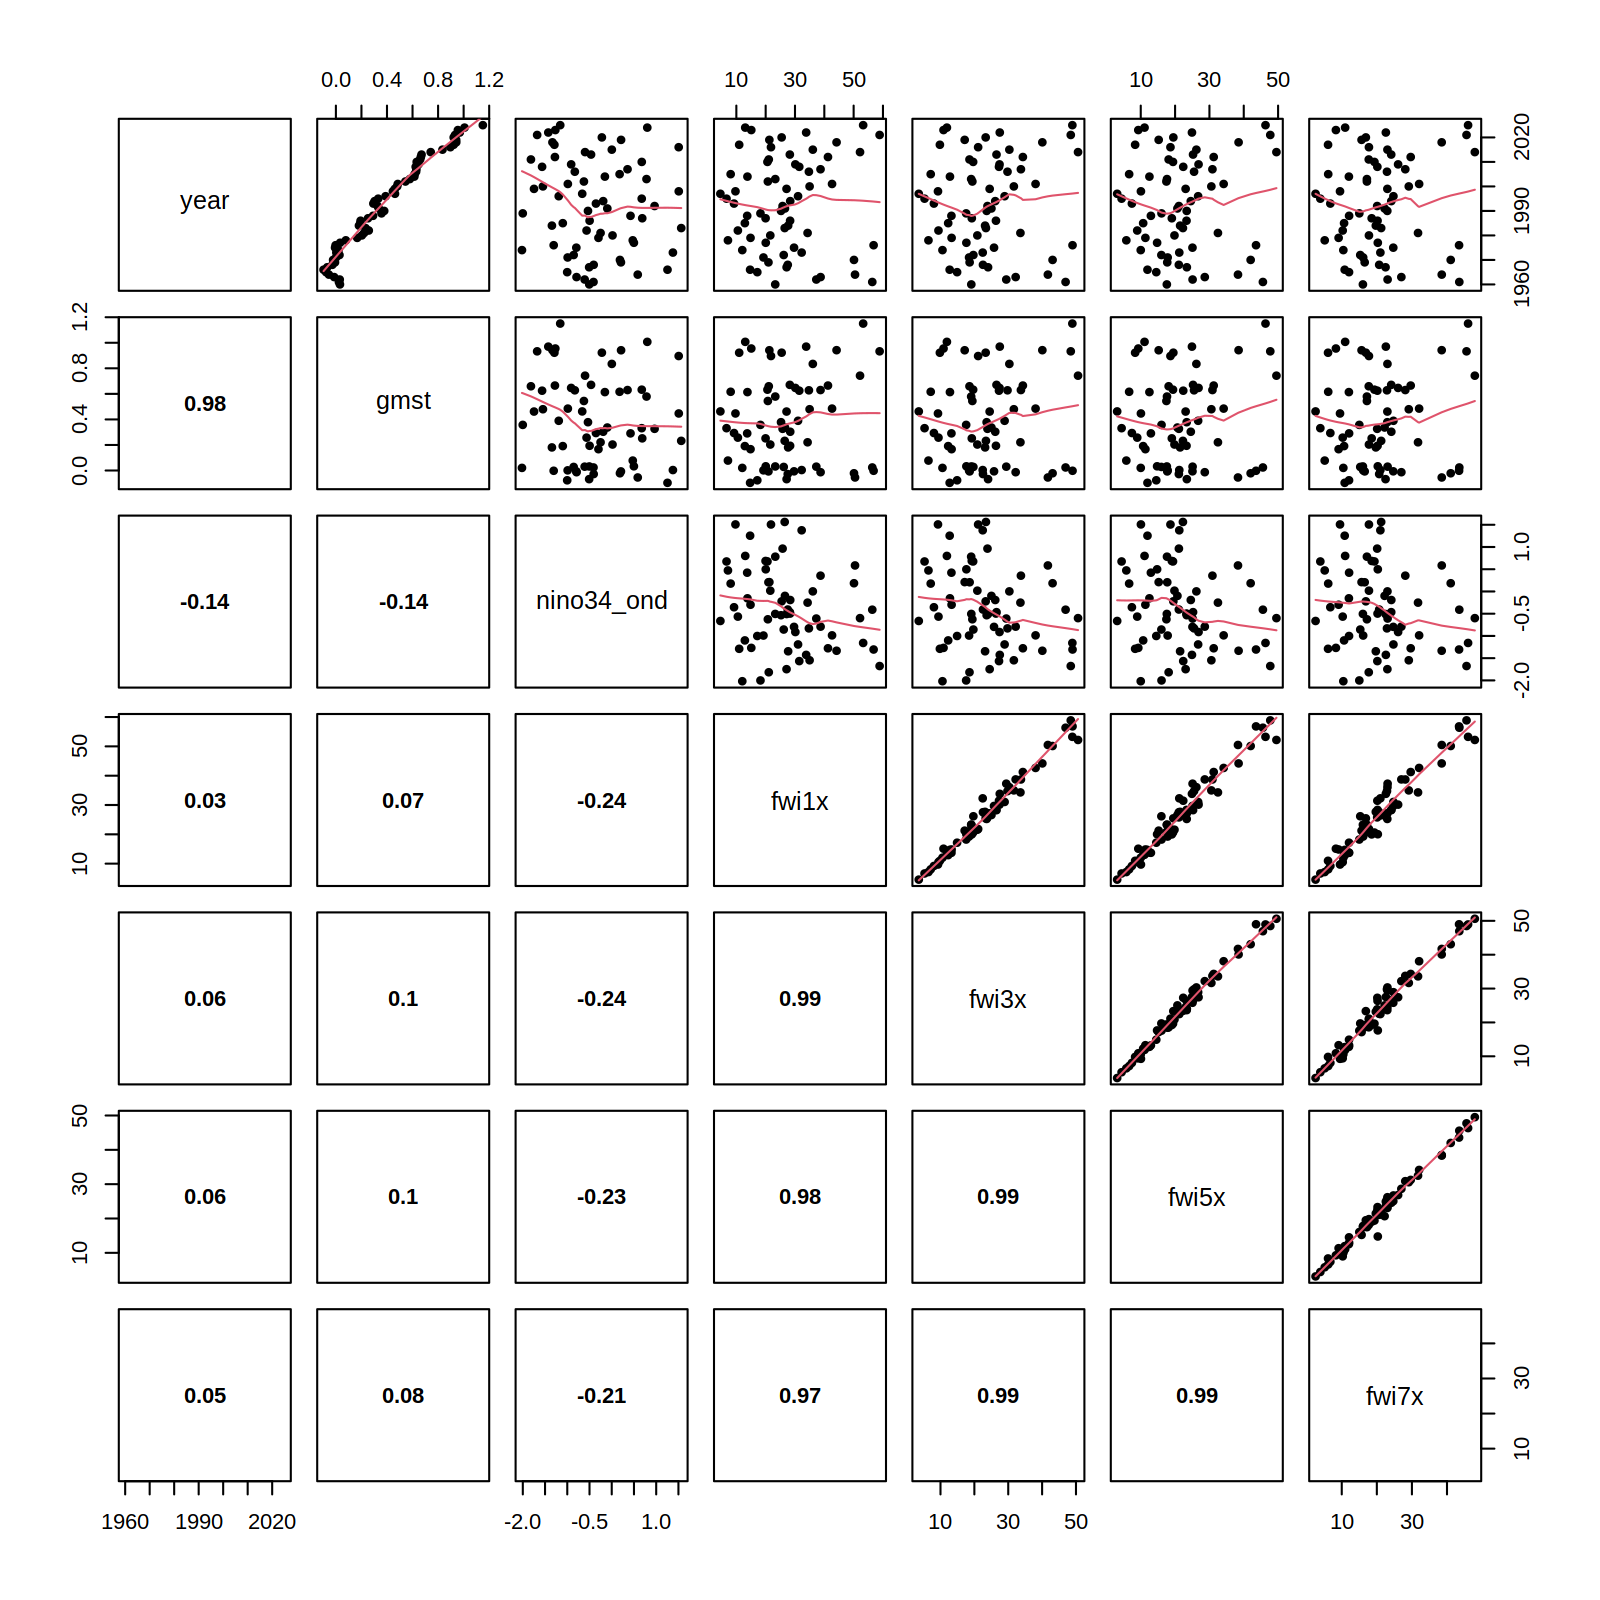

In [126]:
prep_window(c(1,1), h = 8, w = 8)
pairs(df, lower.panel = panel.cor, upper.panel = panel.smooth)

In [127]:
gev_shift <- sapply(colnames(df)[-(1:3)], function(cnm) fit_ns("gev", "shift", df, varnm = cnm, covnm = c("gmst", "nino34_ond"), lower = F), simplify = F)

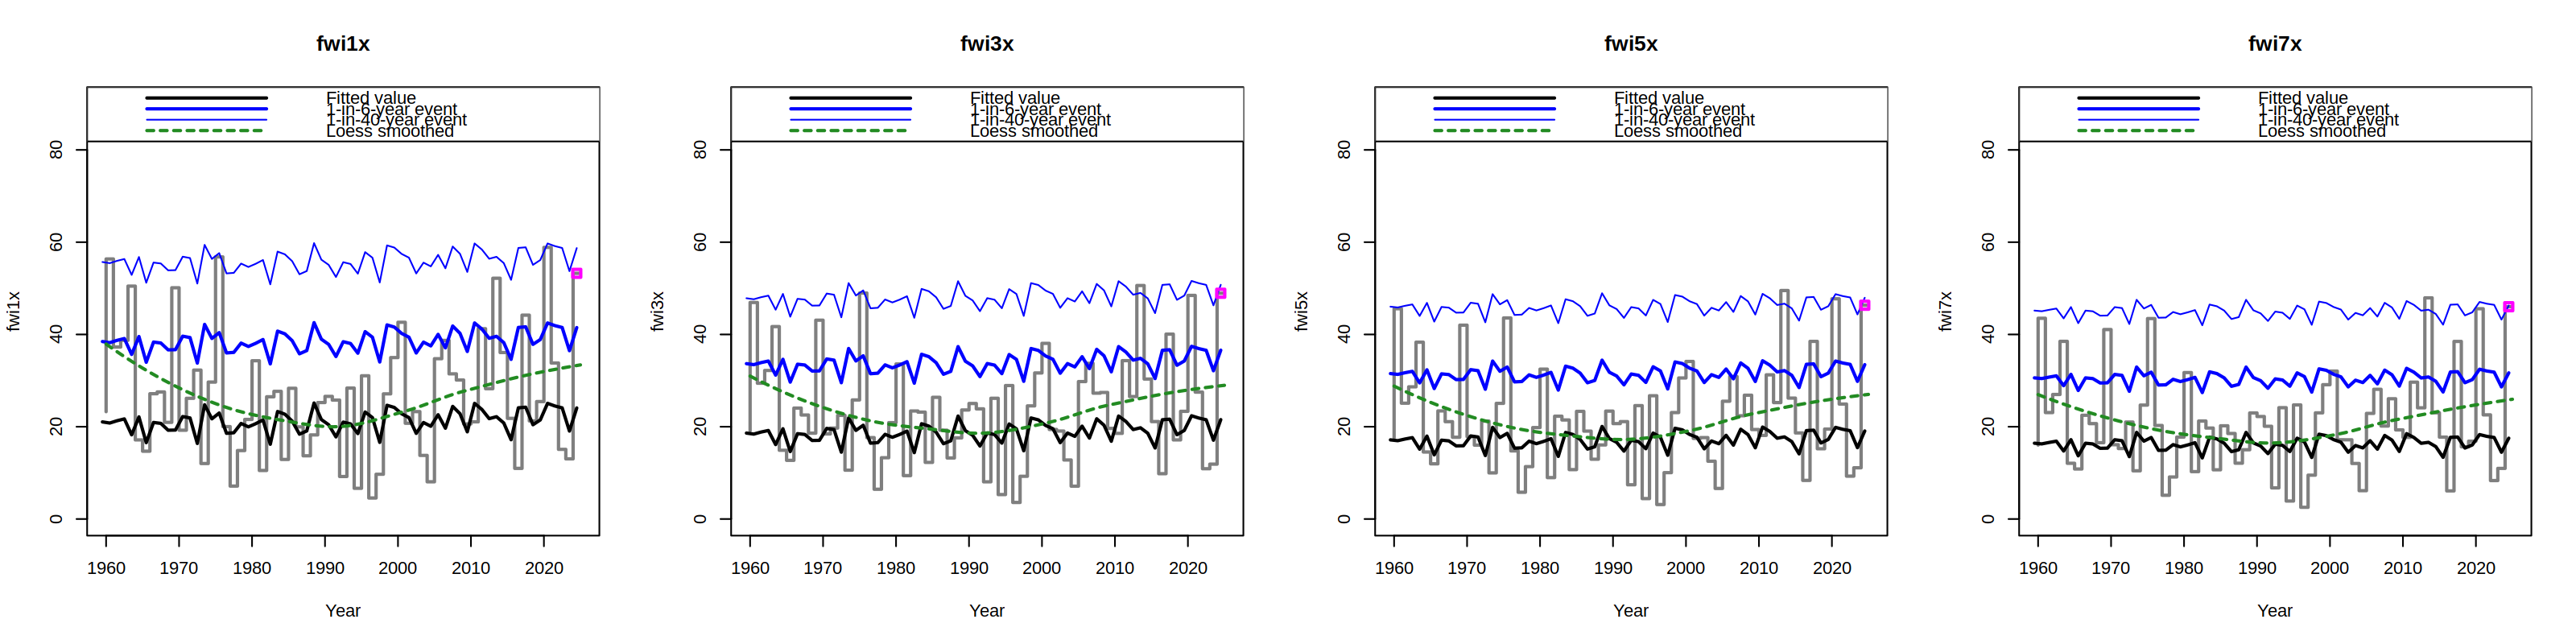

In [75]:
# pretty similar results regardless of the accumulation
prep_window(c(1,4))

ylim = c(0,90)
for(i in 1:4) plot_trend(gev_shift[[i]], main = names(gev_shift)[i], ylim = ylim, add_loess = T)

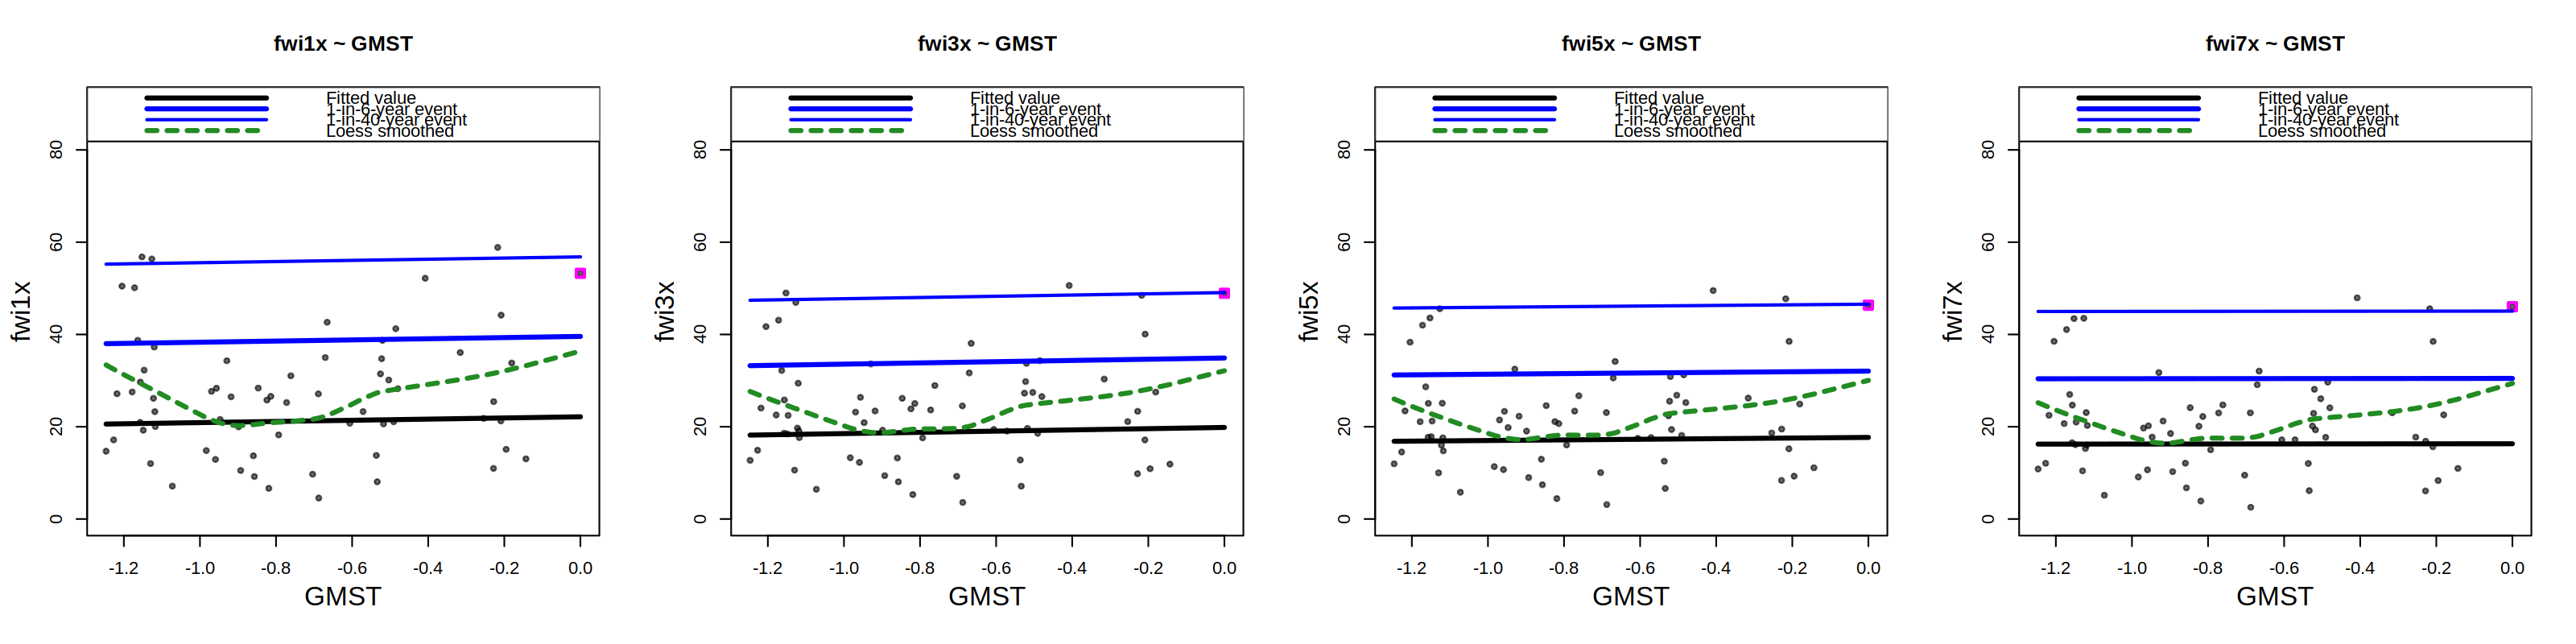

In [76]:
prep_window(c(1,4))
for(i in 1:4) plot_covtrend(gev_shift[[i]], xcov = "gmst", main = paste0(names(gev_shift)[i], " ~ GMST"), ylim = ylim, add_loess = T)

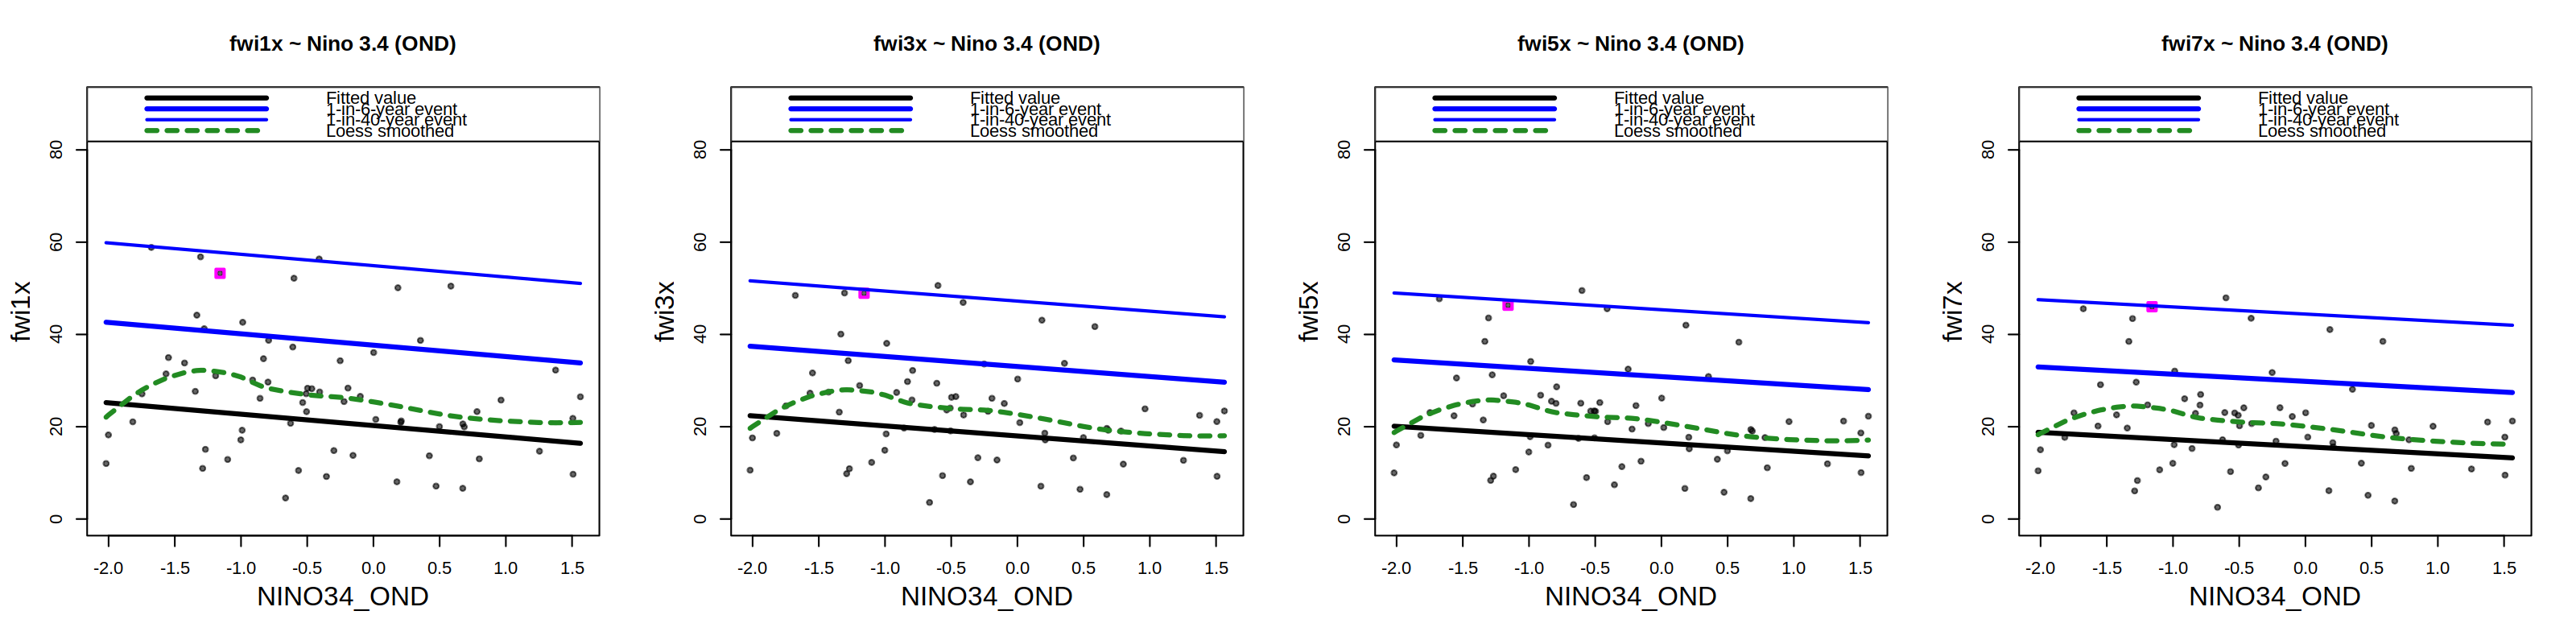

In [77]:
prep_window(c(1,4))
for(i in 1:4) plot_covtrend(gev_shift[[i]], xcov = "nino34_ond", main = paste0(names(gev_shift)[i], " ~ Nino 3.4 (OND)"), ylim = ylim, add_loess = T)

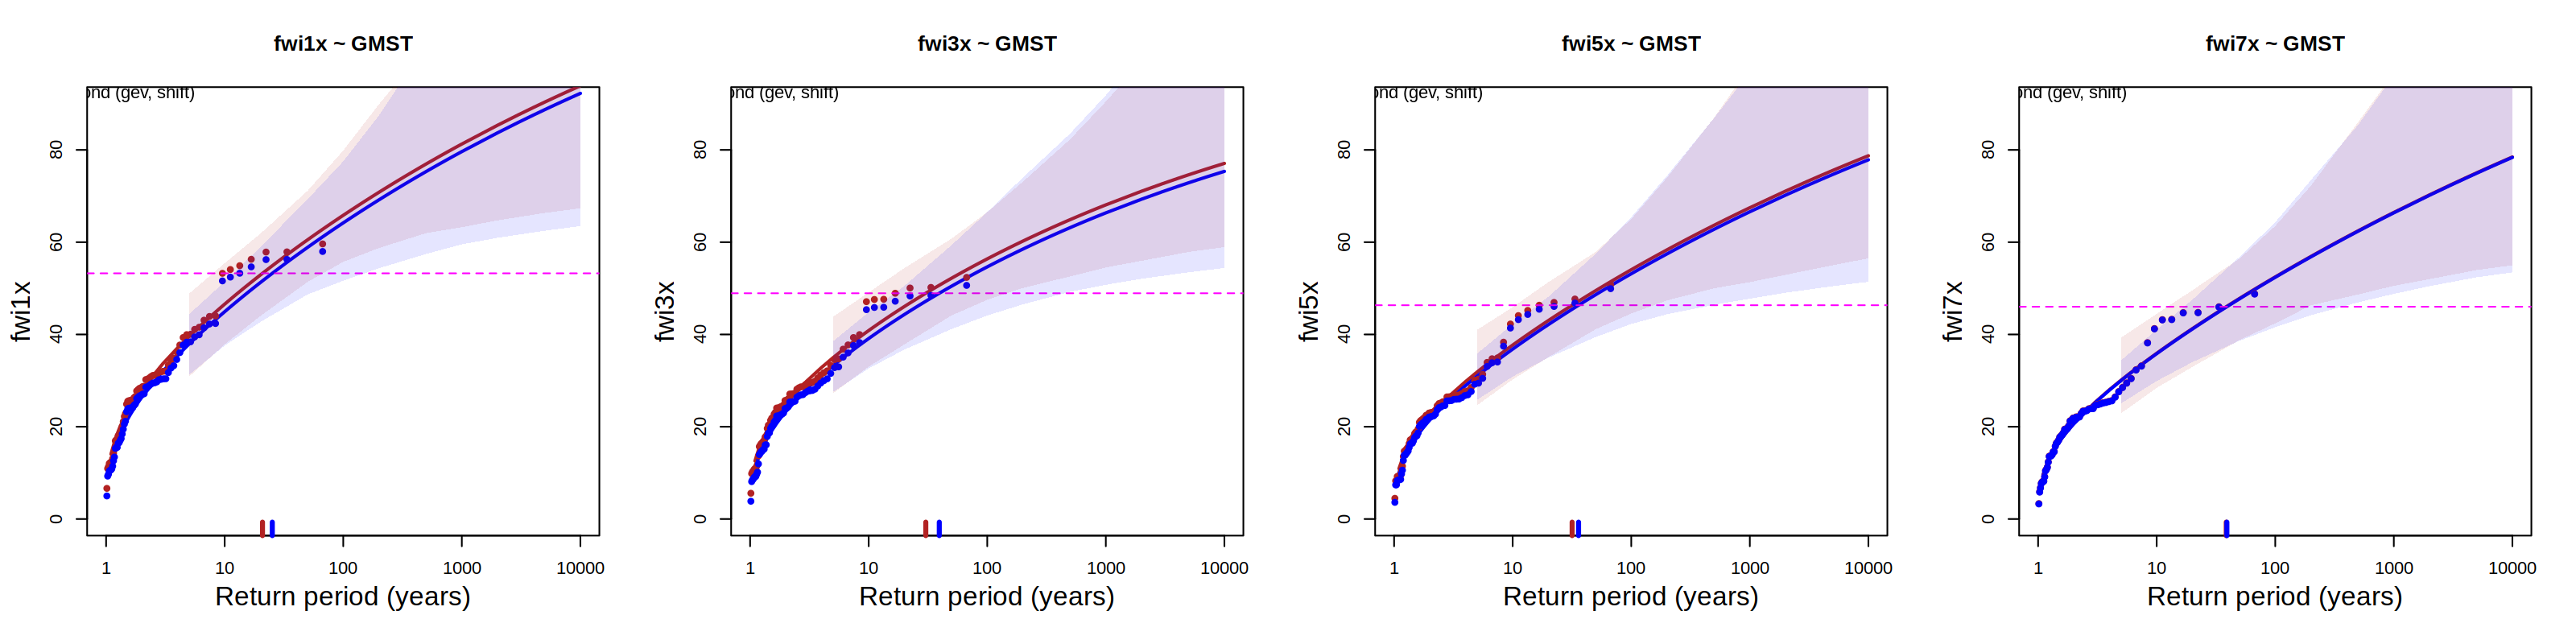

In [78]:
prep_window(c(1,4))

for(i in 1:4) plot_returnlevels(gev_shift[[i]], cov_f = cov_2025, cov_cf = cov_cf["pi",,drop = F], main = paste0(names(gev_shift)[i], " ~ GMST"), ylim = ylim, nsamp = 500)

# fwi1x is slightly better fit, although there is some nonlinearity

In [79]:
boot_res <- abind::abind(sapply(gev_shift, boot_ci, cov_f = cov_2025, cov_cf = cov_cf, simplify = F), along = 0)

In [87]:
boot_res[,"dI_abs_pi",]

boot_res_1940[,"dI_abs_pi",]

,est,2.5%,97.5%
fwi1x,1.63884031,-9.423754,15.01582
fwi3x,1.73086652,-7.921655,14.08480
fwi5x,0.87430544,-7.403462,12.74144
fwi7x,0.08344029,-8.370163,11.77669


,est,2.5%,97.5%
fwi1x,3.650916,-6.998301,14.93986
fwi3x,2.417063,-6.663369,12.46513
fwi5x,1.699129,-6.491622,11.91355
fwi7x,0.936060,-7.468568,11.18755


In [88]:
boot_res[,"dI_rel_pi",]

boot_res_1940[,"dI_rel_pi",]

,est,2.5%,97.5%
fwi1x,3.1755327,-15.03684,39.27626
fwi3x,3.6672024,-13.93357,40.42272
fwi5x,1.9232590,-13.77705,37.93714
fwi7x,0.1816826,-15.39194,34.40165


,est,2.5%,97.5%
fwi1x,7.361269,-11.61599,39.00122
fwi3x,5.196603,-11.98603,34.18527
fwi5x,3.806740,-12.28878,34.61543
fwi7x,2.076728,-13.96554,32.12761


### Shift vs shift+scale

In [175]:
# fit & compare models
mlist <- list("GMST only, 1940-" = fit_ns("gev", "shift", df, varnm = "fwi1x", covnm = c("gmst"), lower = F),
              "GMST + Nino, 1940-" = fit_ns("gev", "shift", df, varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F),
              "GMST only, 1940- ss" = fit_ns("gev", "shiftscale", df, varnm = "fwi1x", covnm = c("gmst"), lower = F),
              "GMST + Nino, 1940- ss" = fit_ns("gev", "shiftscale", df, varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F),
              "GMST only, 1980-" = fit_ns("gev", "shift", df[df$year >= 1980,], varnm = "fwi1x", covnm = c("gmst"), lower = F),
              "GMST + Nino, 1980-" = fit_ns("gev", "shift", df[df$year >= 1980,], varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F),
              "GMST only, 1980- ss" = fit_ns("gev", "shiftscale", df[df$year >= 1980,], varnm = "fwi1x", covnm = c("gmst"), lower = F),
              "GMST + Nino, 1980- ss" = fit_ns("gev", "shiftscale", df[df$year >= 1980,], varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F))

In [175]:
# in both time periods, model fit is better when we include Nino as well as GMST
# shift+scale is better in the short term - because the data during the 1980s is so much less variable
data.frame(sapply(mlist, aic))

# final model: GMST + Nino, use all available data

,sapply.mlist..aic.
,<dbl>
"GMST only, 1940-",692.3381
"GMST + Nino, 1940-",690.5884
"GMST only, 1940- ss",694.2836
"GMST + Nino, 1940- ss",693.0653
"GMST only, 1980-",364.5206
"GMST + Nino, 1980-",361.5636
"GMST only, 1980- ss",360.6590
"GMST + Nino, 1980- ss",360.9218


### Sensitivity to length of time series

In [124]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2025 Jan FWI should all be labelled as 2025
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
df$gmst <- df$gmst - df$gmst[df$year == 2025]

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))

In [125]:
df <- merge(merge(merge(merge(merge(gmst, nino), 
                  read.csv("ts/era5_fwi1x-jan_socal-baja.csv")), read.csv("ts/era5_fwi3x-jan_socal-baja.csv")), read.csv("ts/era5_fwi5x-jan_socal-baja.csv")), read.csv("ts/era5_fwi7x-jan_socal-baja.csv"))
df <- df[df$year >= 1960,]

cov_2025 = df[df$year == 2025, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2025 - c(1.3, 0),
               "neut" = c(cov_2025$gmst, 0),
               "1960s" = c(mean(df[(df$year >= 1960) & (df$year < 1970),"gmst"]), cov_2025$nino34_ond))

In [98]:
by_ts_length <- setNames(sapply(c(1940,1960,1980), function(y) fit_ns("gev", "shift", df[df$year >= y,], varnm = "fwi1x", covnm = c("gmst", "nino34_ond"), lower = F), simplify = F), c("1940-2025", "1960-2025", "1980-2025"))

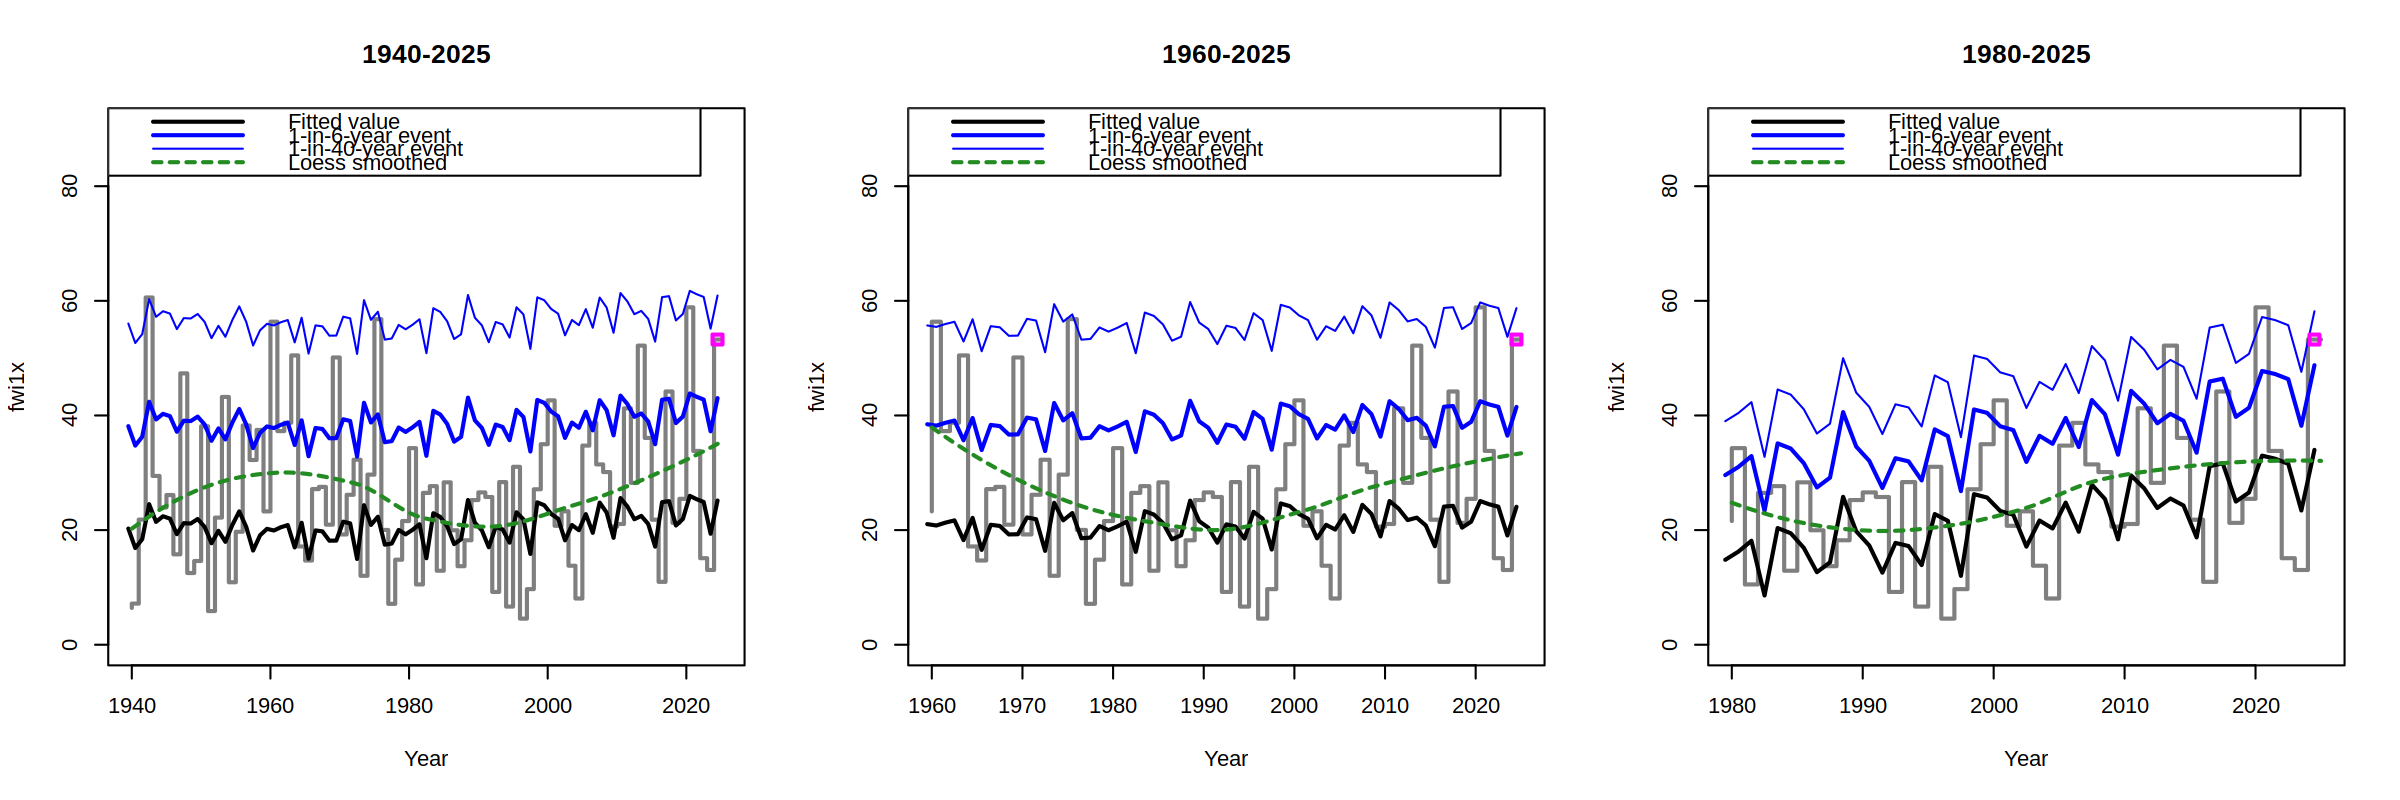

In [99]:
# pretty similar results regardless of the accumulation
prep_window(c(1,3))

ylim = c(0,90)
for(i in 1:3) plot_trend(by_ts_length[[i]], main = names(by_ts_length)[i], ylim = ylim, add_loess = T)

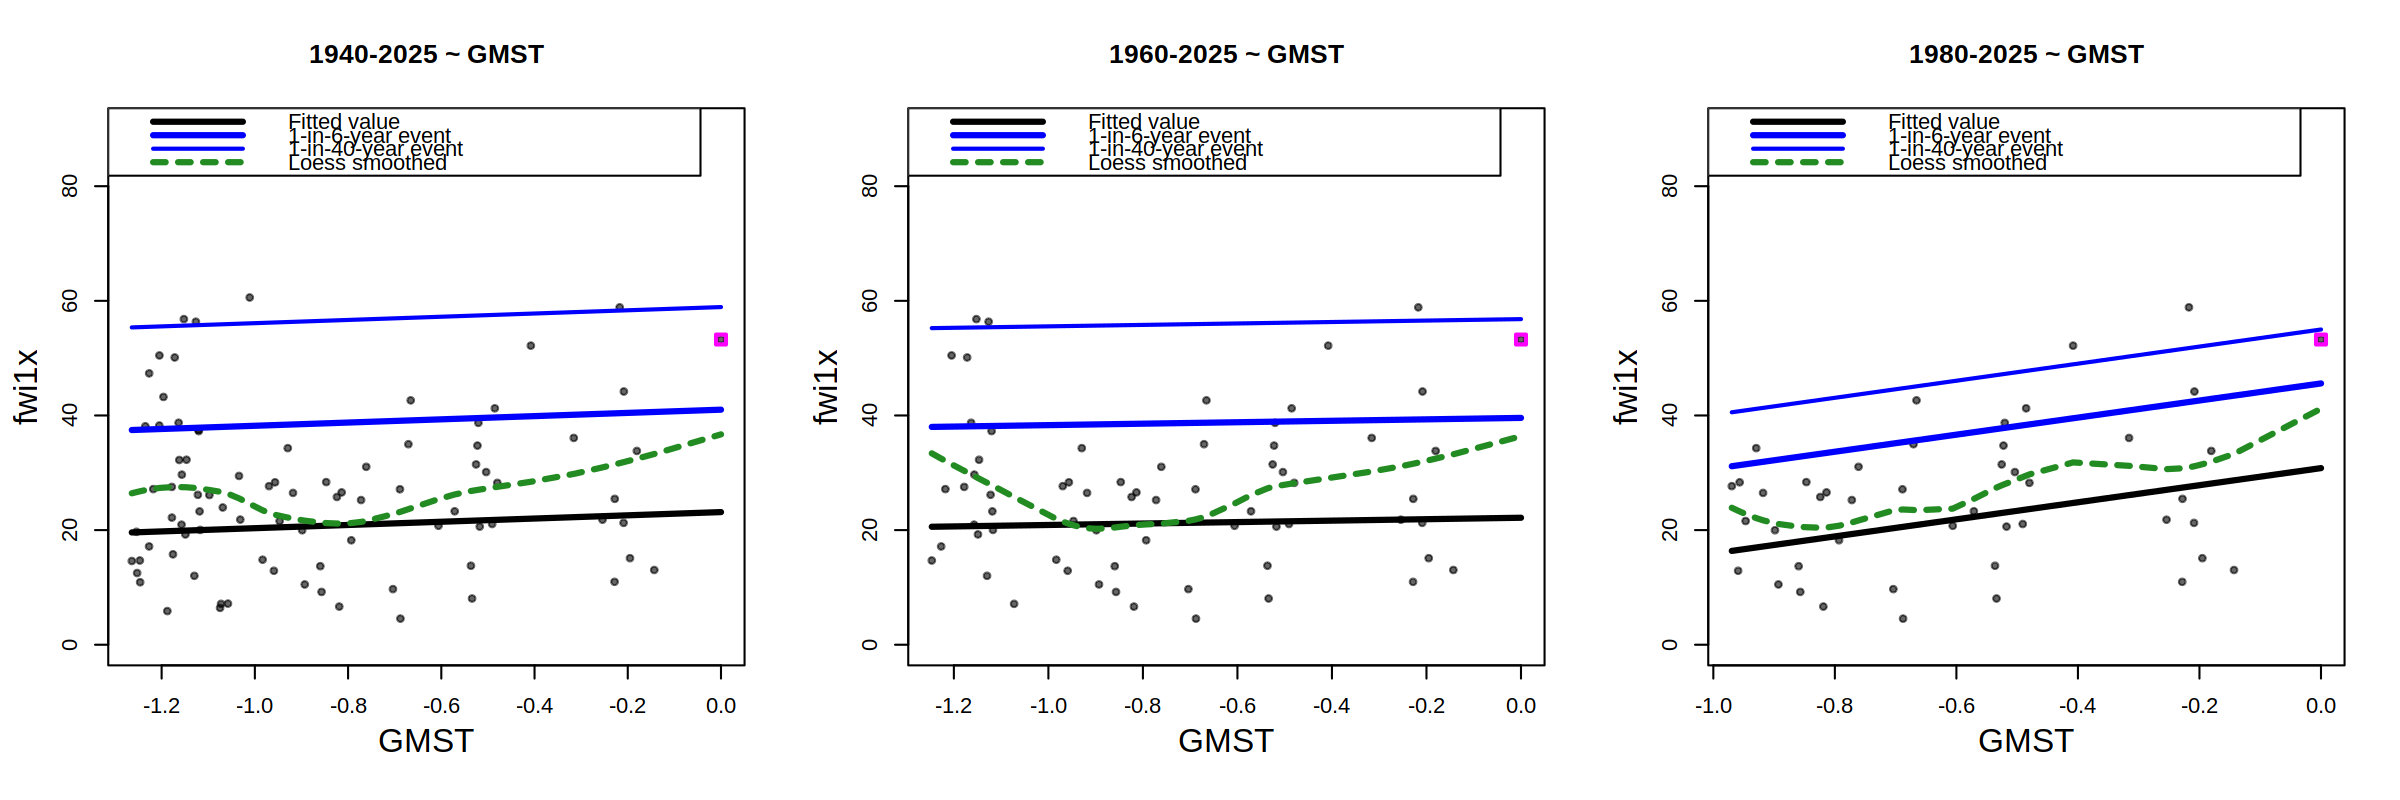

In [100]:
prep_window(c(1,3))
for(i in 1:3) plot_covtrend(by_ts_length[[i]], xcov = "gmst", main = paste0(names(by_ts_length)[i], " ~ GMST"), ylim = ylim, add_loess = T)

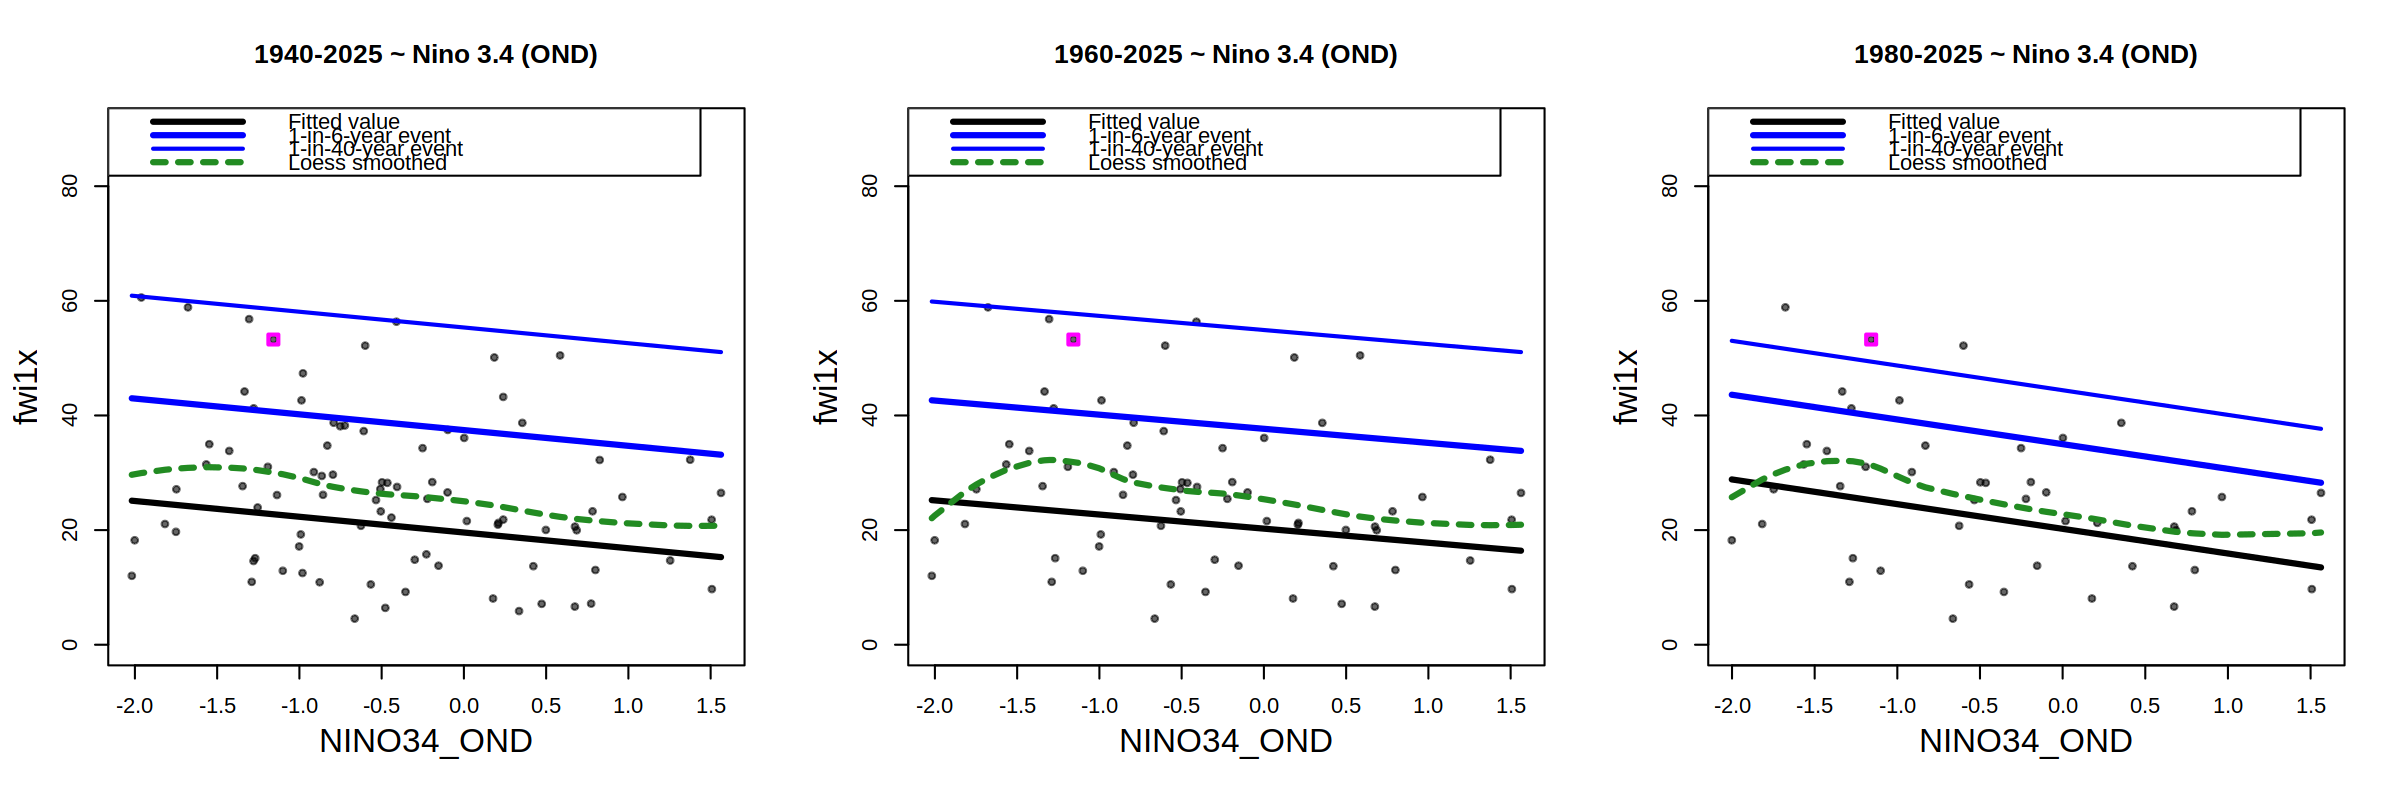

In [101]:
prep_window(c(1,3))
for(i in 1:3) plot_covtrend(by_ts_length[[i]], xcov = "nino34_ond", main = paste0(names(by_ts_length)[i], " ~ Nino 3.4 (OND)"), ylim = ylim, add_loess = T)

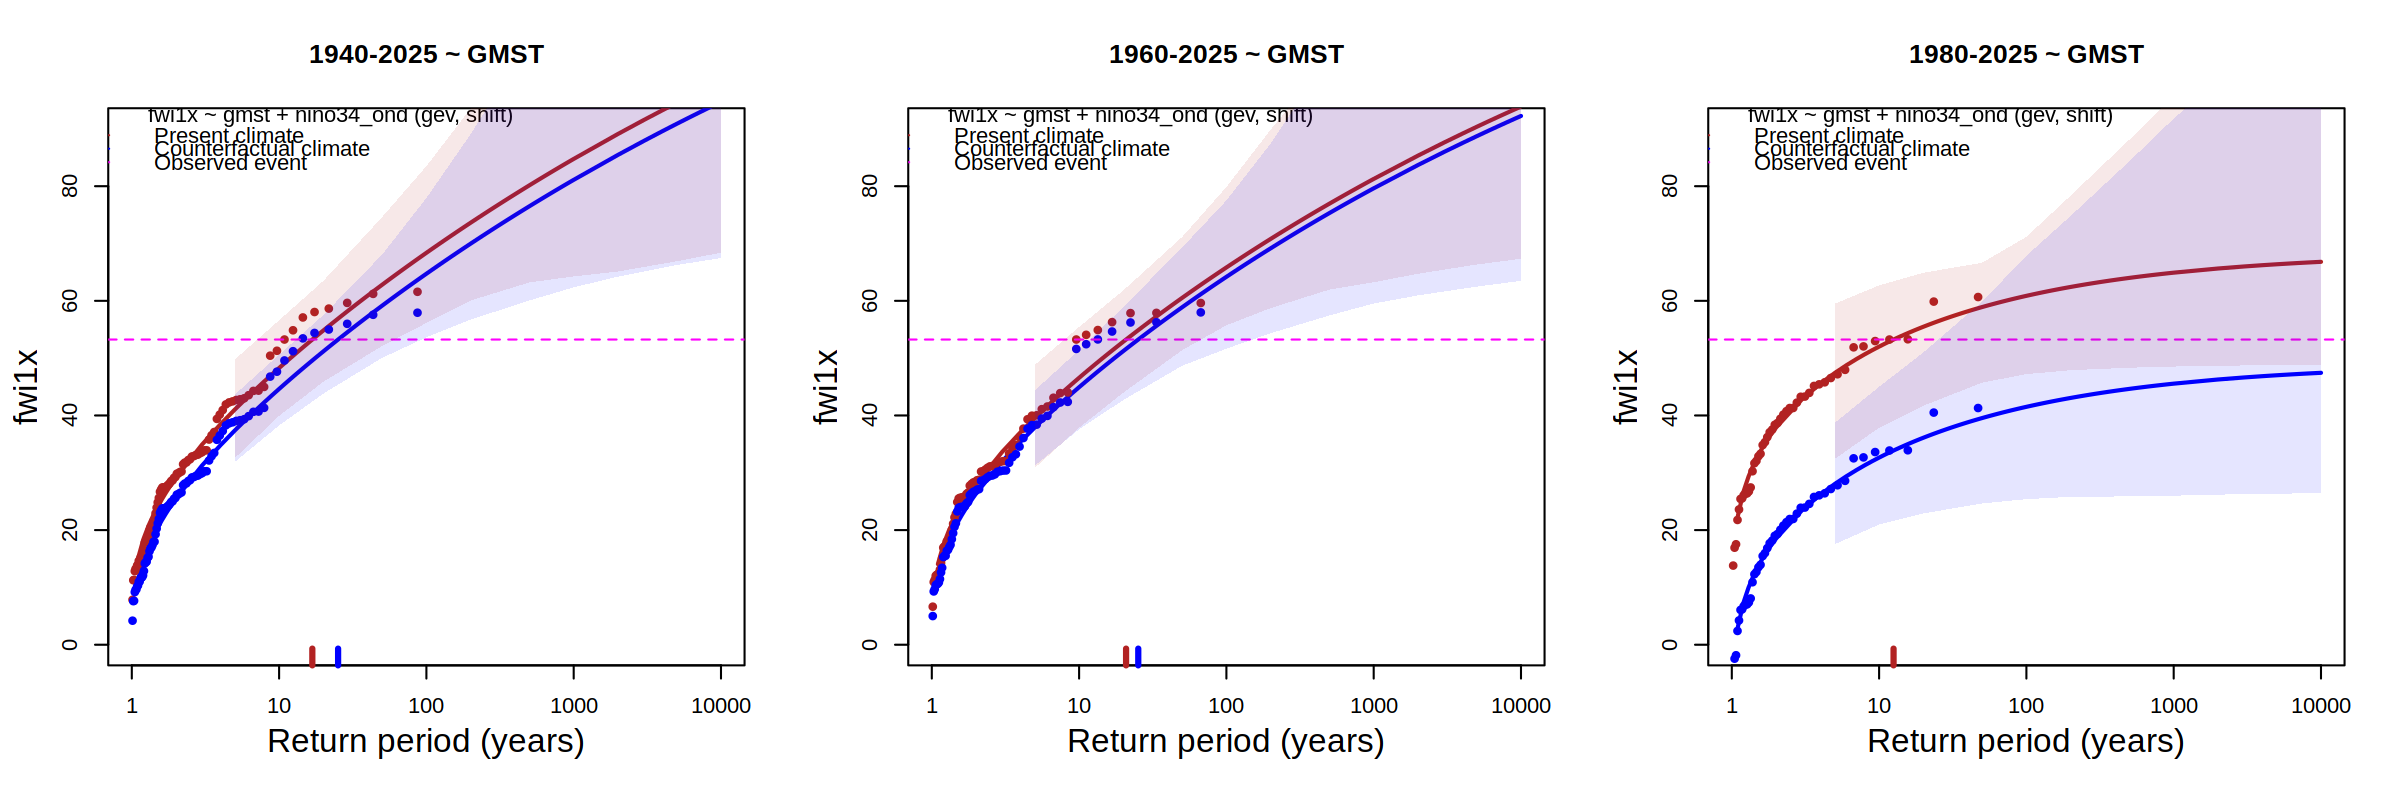

In [102]:
prep_window(c(1,3))

for(i in 1:3) plot_returnlevels(by_ts_length[[i]], cov_f = cov_2025, cov_cf = cov_cf["pi",,drop = F], main = paste0(names(by_ts_length)[i], " ~ GMST"), ylim = ylim, nsamp = 500)

# OND SPI

In [38]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2024 OND precip should all be labelled as 2024
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
gmst$year <- gmst$year - 1

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino$year <- nino$year - 1

In [39]:
df <- merge(merge(gmst, nino), read.csv("ts/era5_spi-ond_socal-baja.csv"))

In [40]:
nsamp <- 1000
nino_corr <- data.frame(t(c(cor(df$nino34_ond, df$spi_ond), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(df), replace = T), c("nino34_ond", "spi_ond")])[1,2]), c(0.025, 0.975), na.rm = T))  )                                )


In [41]:
nino_corr

V1,X2.5.,X97.5.
<dbl>,<dbl>,<dbl>
0.2009473,-1.82111e-05,0.3821761


In [42]:
cov_2024 = df[df$year == 2024, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2024 - c(1.3, 0),
               "neut" = c(cov_2024$gmst, 0),
               "pineut" = c(-1.3, 0),
               "2023" = c(cov_2024$gmst, df$nino34_ond[df$year == 2023]))

In [43]:
# fit chosen model
mdl_spi_shift <- fit_ns("norm", "shift", df, varnm = "spi_ond", covnm = c("gmst", "nino34_ond"), lower = T)

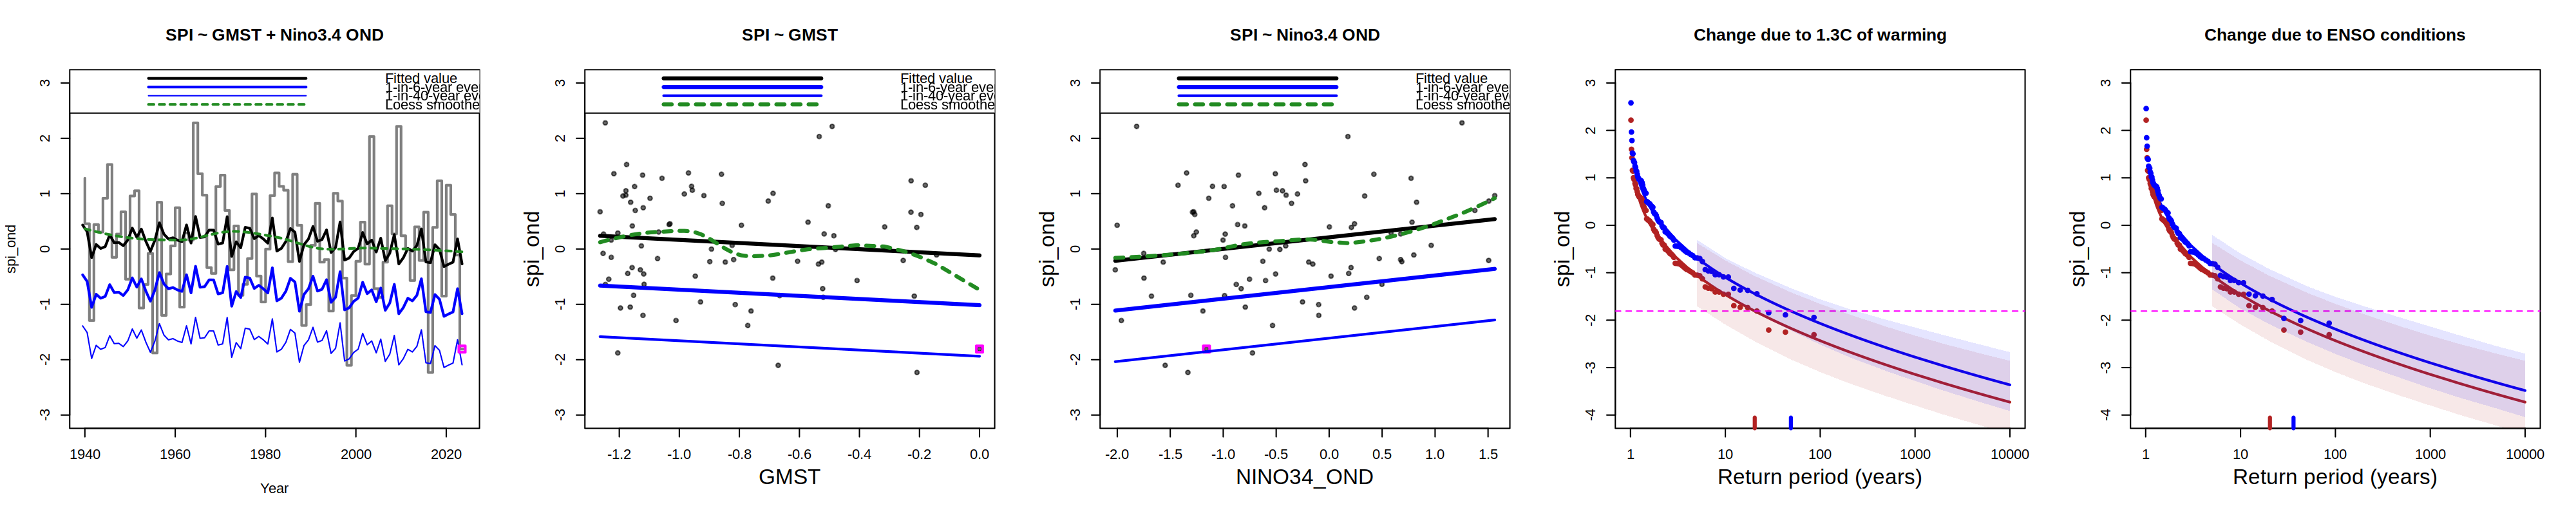

In [44]:
prep_window(c(1,5))

plot_trend(mdl_spi_shift, add_loess = T, main = "SPI ~ GMST + Nino3.4 OND")
plot_covtrend(mdl_spi_shift, xcov = "gmst", add_loess = T, main = "SPI ~ GMST")
plot_covtrend(mdl_spi_shift, xcov = "nino34_ond", add_loess = T, main = "SPI ~ Nino3.4 OND")

plot_returnlevels(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop=F], main = "Change due to 1.3C of warming")
plot_returnlevels(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf["neut",,drop=F], main = "Change due to ENSO conditions")

In [45]:
boot_res <- boot_ci(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf)
write.csv(boot_res, "res/res-obs_spi-ond_era5.csv")

In [48]:
1.773*2.406

[1] 4.265838

In [46]:
round(boot_res, 3)

,est,2.5%,97.5%
mu0,-0.026,-0.597,0.553
sigma0,0.930,0.783,1.034
alpha_gmst,-0.280,-0.898,0.327
alpha_nino34_ond,0.210,-0.019,0.430
disp,-3.451,-30.651,46.377
event_magnitude,-1.808,-1.808,-1.808
return_period,20.411,5.895,160.552
PR_pi,2.406,0.329,20.932
dI_abs_pi,-0.364,-1.168,0.425
dI_rel_pi,25.213,-19.031,182.568


## ngridclim

In [4]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2024 OND precip should all be labelled as 2024
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
gmst$year <- gmst$year - 1

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino$year <- nino$year - 1

In [6]:
df <- merge(merge(gmst, nino), read.csv("ts/ngridclim_spi-ond_socal-baja.csv"))

In [7]:
nsamp <- 1000
nino_corr <- data.frame(t(c(cor(df$nino34_ond, df$spi_ond), quantile(sapply(1:nsamp, function(i) cor(df[sample(1:nrow(df), replace = T), c("nino34_ond", "spi_ond")])[1,2]), c(0.025, 0.975), na.rm = T))  )                                )


In [8]:
nino_corr

V1,X2.5.,X97.5.
<dbl>,<dbl>,<dbl>
0.1086653,-0.06805179,0.2617055


In [24]:
cov_2024 <- data.frame(gmst = gmst$gmst[gmst$year == 2024], "nino34_ond" = nino$nino34_ond[nino$year == 2024])
cov_cf <- rbind("pi" = cov_2024 - c(1.3,0),
                "neut" = c(gmst = gmst$gmst[gmst$year == 2024], nino34_ond = 0),
                "pineut" = c(gmst = -1.3, nino34_ond = 0))

In [15]:
# fit chosen model
mdl_spi_shift <- fit_ns("norm", "shift", df, varnm = "spi_ond", covnm = c("gmst", "nino34_ond"), lower = T)

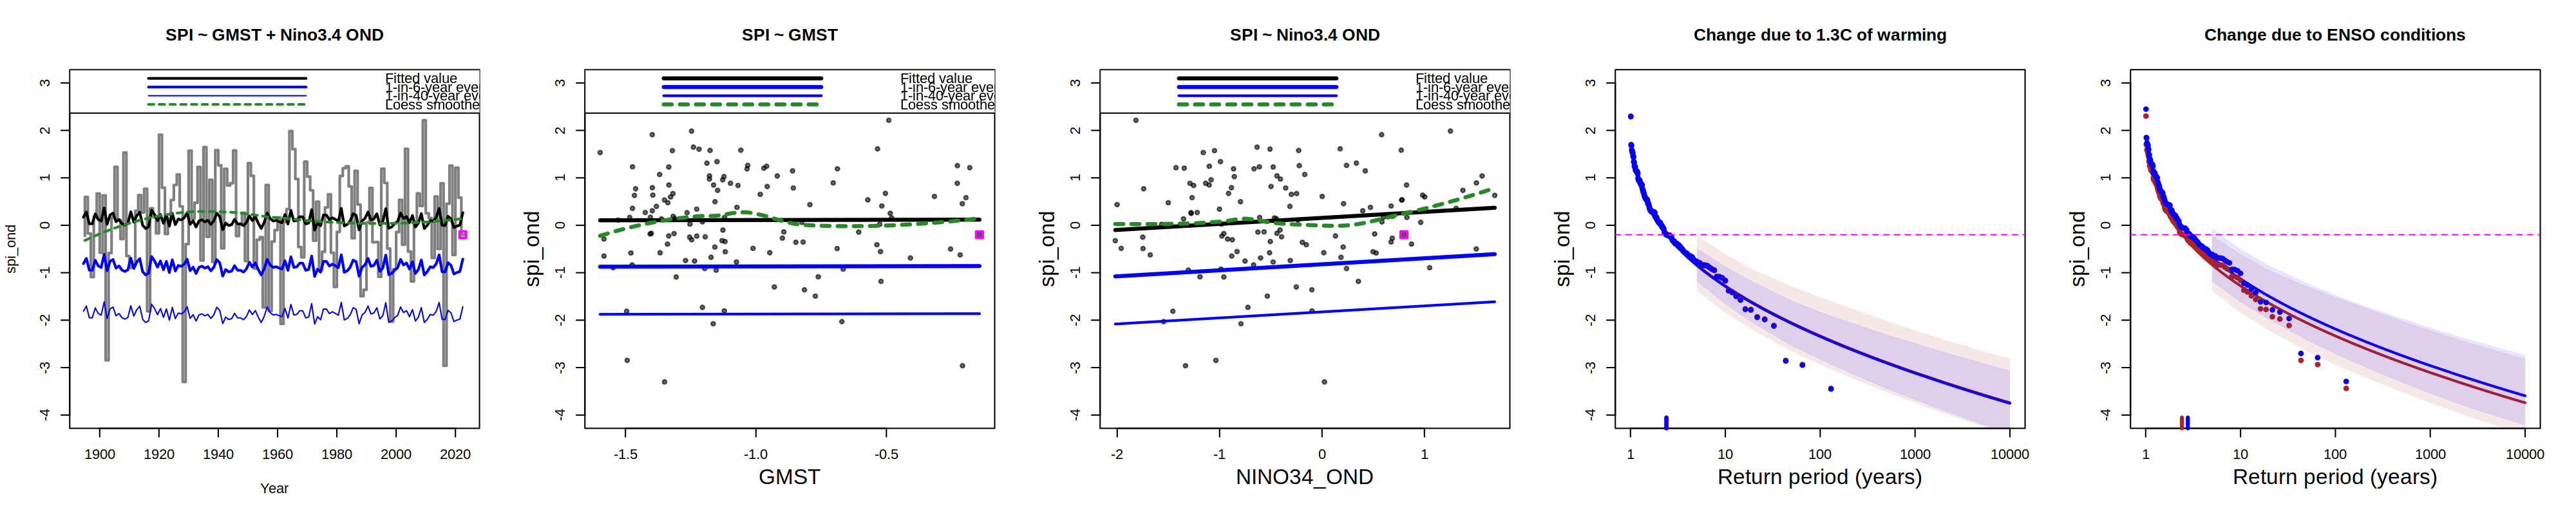

In [16]:
prep_window(c(1,5))

plot_trend(mdl_spi_shift, add_loess = T, main = "SPI ~ GMST + Nino3.4 OND")
plot_covtrend(mdl_spi_shift, xcov = "gmst", add_loess = T, main = "SPI ~ GMST")
plot_covtrend(mdl_spi_shift, xcov = "nino34_ond", add_loess = T, main = "SPI ~ Nino3.4 OND")

plot_returnlevels(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop=F], main = "Change due to 1.3C of warming")
plot_returnlevels(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf["neut",,drop=F], main = "Change due to ENSO conditions")

In [25]:
boot_res <- boot_ci(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf)
write.csv(boot_res, "res/res-obs_spi-ond_ngridclim.csv")

In [26]:
round(boot_res, 3)

,est,2.5%,97.5%
mu0,0.166,-0.345,0.770
sigma0,1.011,0.861,1.145
alpha_gmst,0.009,-0.429,0.511
alpha_nino34_ond,0.127,-0.078,0.314
disp,53.355,-46.715,55.065
event_magnitude,-0.199,-0.199,-0.199
return_period,2.411,1.600,4.905
PR_pi,0.989,0.467,1.622
dI_abs_pi,0.012,-0.558,0.664
dI_rel_pi,-5.776,-975.402,559.596


## Model selection

### Shift vs shift+scale

In [24]:
mdl_spi_shift <- fit_ns("norm", "shift", df, varnm = "spi_ond", covnm = c("gmst", "nino34_ond"), lower = T)
mdl_spi_shiftscale <- fit_ns("norm", "shiftscale", df, varnm = "spi_ond", covnm = c("gmst", "nino34_ond"), lower = T)

In [25]:
# slightly better fit from shift only - 
sapply(list("Shift" = mdl_spi_shift, "Shift + scale" = mdl_spi_shiftscale), function(mdl) c(aic(mdl), rsquared(mdl)*100)) # slightly better fit from shift only

,Shift,Shift + scale
,236.857755,237.442945
r2,5.068434,4.941936
r2.adj,2.753030,2.623446


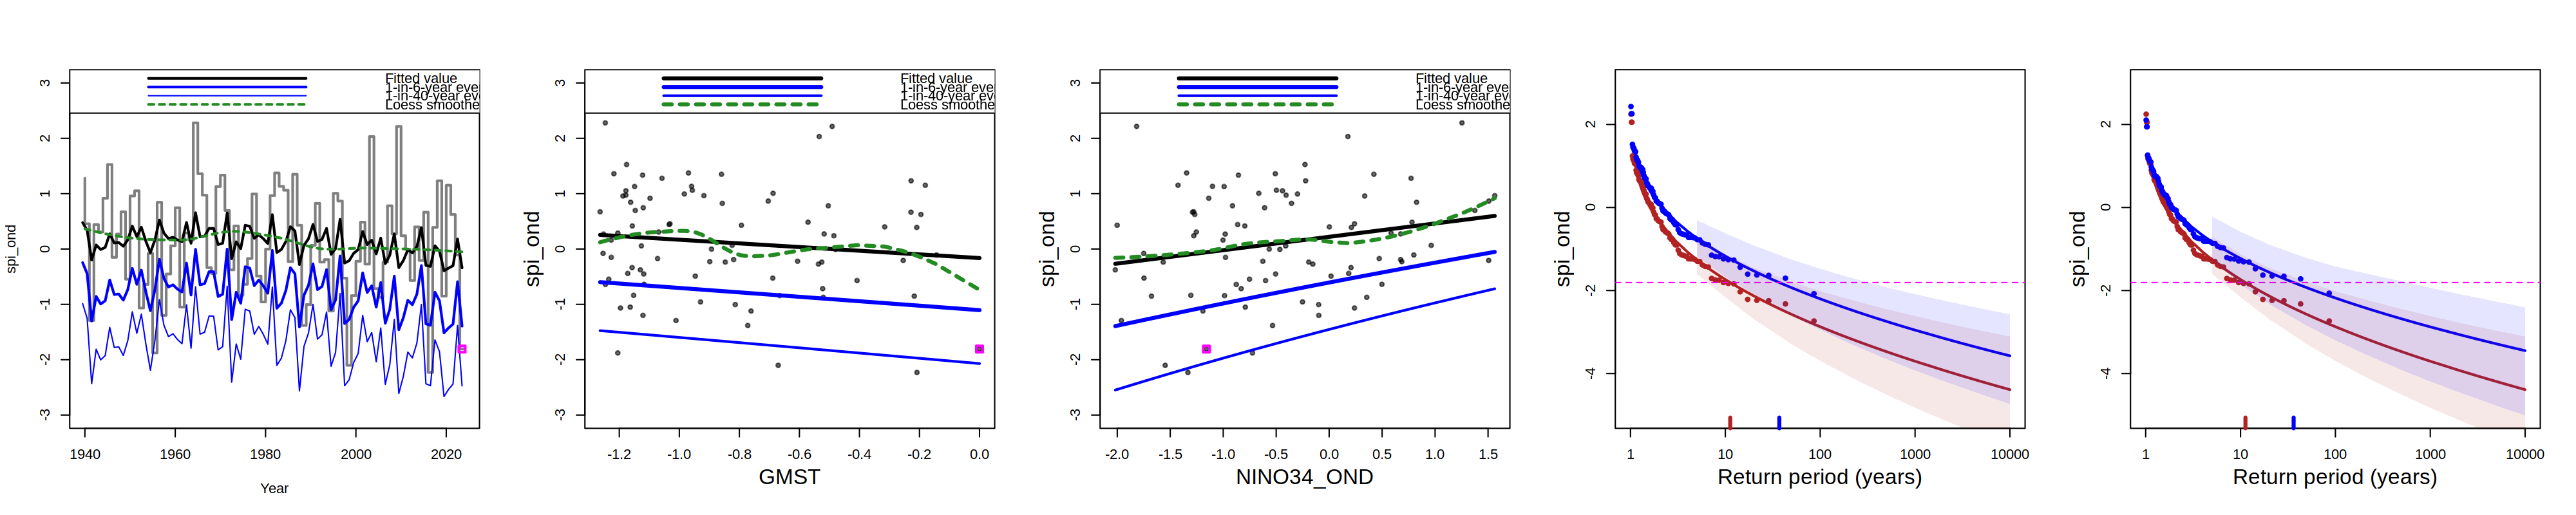

In [26]:
prep_window(c(1,5))

plot_trend(mdl_spi_shiftscale, add_loess = T)
plot_covtrend(mdl_spi_shiftscale, xcov = "gmst", add_loess = T)
plot_covtrend(mdl_spi_shiftscale, xcov = "nino34_ond", add_loess = T)

plot_returnlevels(mdl_spi_shiftscale, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop=F], nsamp = 50)
plot_returnlevels(mdl_spi_shiftscale, cov_f = cov_2024, cov_cf = cov_cf["neut",,drop=F], nsamp = 50)

In [193]:
boot_res_shift <- boot_ci(mdl_spi_shift, cov_f = cov_2024, cov_cf = cov_cf)
boot_res_shiftscale <- boot_ci(mdl_spi_shiftscale, cov_f = cov_2024, cov_cf = cov_cf)

In [218]:
write.csv(boot_res_shift, "res/res-obs_spi-shift_era5.csv")
write.csv(boot_res_shiftscale, "res/res-obs_spi-shiftscale_era5.csv")

In [222]:
round(boot_res_shift, 3)


,est,2.5%,97.5%
mu0,-0.026,-0.604,0.563
sigma0,0.930,0.785,1.030
alpha_gmst,-0.274,-0.901,0.328
alpha_nino34_ond,0.217,-0.014,0.434
disp,-3.354,-35.056,34.100
event_magnitude,-1.786,-1.786,-1.786
return_period,19.108,5.643,142.460
PR_pi,2.333,0.327,20.192
dI_abs_pi,-0.356,-1.172,0.427
dI_rel_pi,24.929,-19.278,191.110


# End of drought season

In [17]:
# load covariates & adjust to align with variable years: 2024 GMST, 2024 OND Nino3.4, 2024 end of season should all be labelled as 2024
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino$year <- nino$year - 1

In [18]:
df <- merge(merge(gmst, nino), read.csv("ts/era5_drought-end-date.csv", col.names = c("z", "dc_doy", "year"))[,c("year", "dc_doy")])

In [19]:
cov_2024 = df[df$year == 2024, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2024 - c(1.3, 0),
               "neut" = c(cov_2024$gmst, 0),
               "nino2023" = c(cov_2024$gmst, df$nino34_ond[df$year == 2023]))

In [20]:
# fit chosen model
mdl_doy <- fit_ns("norm", "shift", df, varnm = "dc_doy", covnm = c("gmst", "nino34_ond"), lower = F, ev = NA)

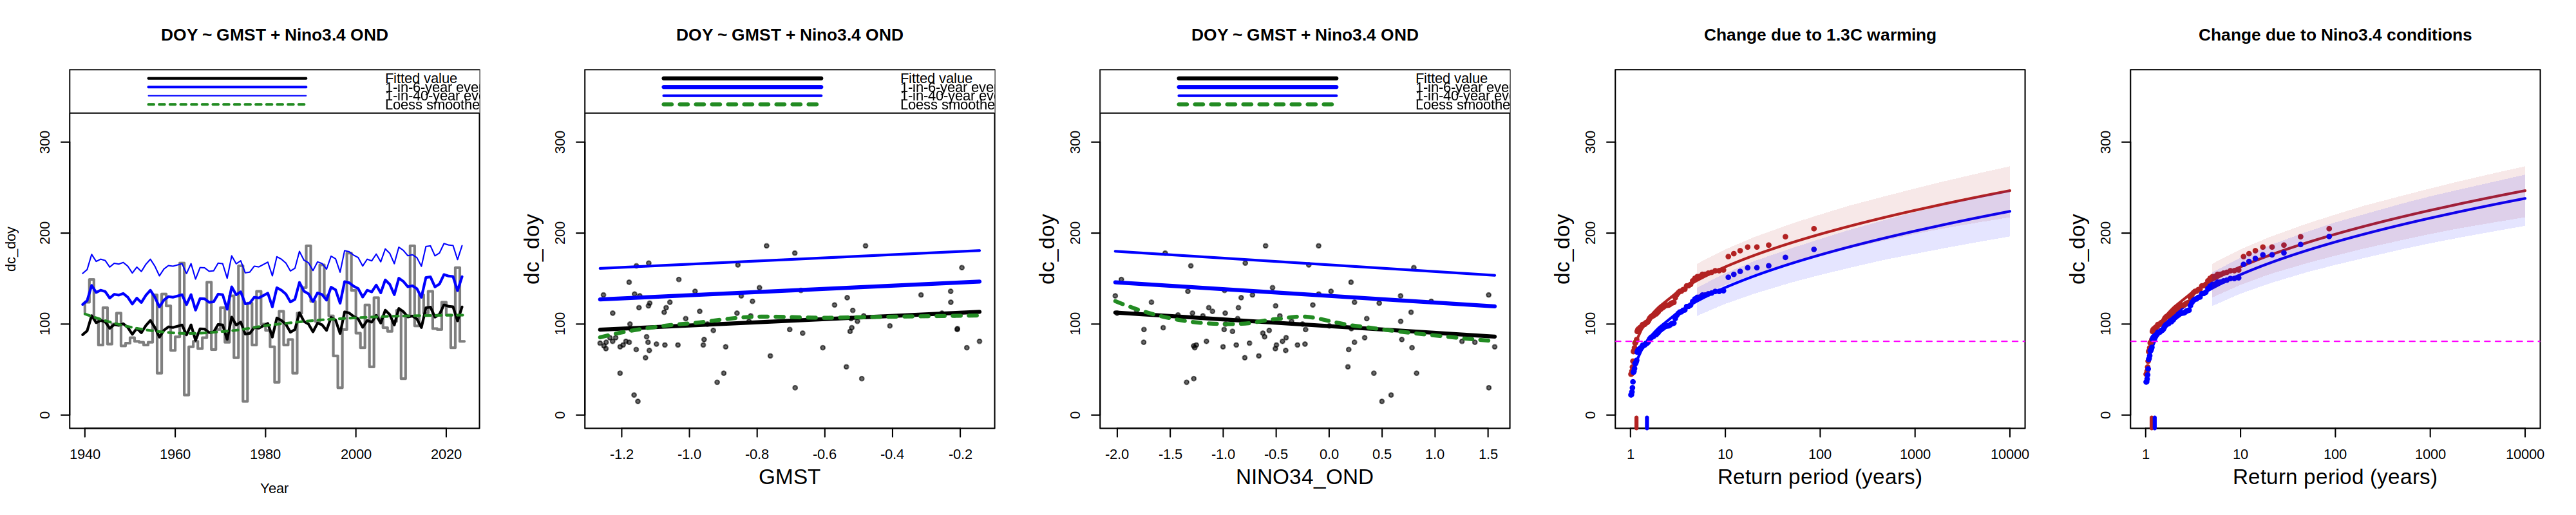

In [21]:
prep_window(c(1,5))
ylim = c(0,365)

plot_trend(mdl_doy, add_loess = T, ylim = ylim, main = "DOY ~ GMST + Nino3.4 OND", ev = 152, ev_year = 2030)
plot_covtrend(mdl_doy, xcov = "gmst", add_loess = T, ylim = ylim, ev = 152, ev_x = 84, main = "DOY ~ GMST + Nino3.4 OND")
plot_covtrend(mdl_doy, xcov = "nino34_ond", add_loess = T, ylim = ylim, ev = 152, ev_x = 84, main = "DOY ~ GMST + Nino3.4 OND")

plot_returnlevels(mdl_doy, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop=F], ylim = ylim, main = "Change due to 1.3C warming")
plot_returnlevels(mdl_doy, cov_f = cov_2024, cov_cf = cov_cf["neut",,drop=F], ylim = ylim, main = "Change due to Nino3.4 conditions")

In [22]:
boot_res <- boot_ci(mdl_doy, cov_f = cov_2024, cov_cf = cov_cf, rp = 10)
write.csv(boot_res, "res/res-obs_dc-doy_era5.csv")

In [23]:
round(boot_res, 3)

,est,2.5%,97.5%
mu0,112.798,92.228,130.992
sigma0,34.364,28.436,39.296
alpha_gmst,17.490,-2.101,37.779
alpha_nino34_ond,-7.385,-15.447,1.161
disp,0.289,0.234,0.339
event_magnitude,162.887,143.100,182.135
return_period,10.000,10.000,10.000
PR_pi,3.847,0.866,33.735
dI_abs_pi,22.738,-2.731,49.112
dI_rel_pi,16.224,-1.805,38.256


# Drought onset

In [8]:
# load covariates & adjust to align with variable years: 2025 GMST, 2024 OND Nino3.4, 2024 OND precip should all be labelled as 2024
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
gmst$year <- gmst$year - 1

nino <- read.csv("ts/nino34_ond.csv", col.names = c("year", "nino34_ond"))
nino$year <- nino$year - 1

df <- merge(merge(gmst, nino), read.csv("ts/era5_doy-clim30pc.csv"))

cov_2024 = df[df$year == 2024, c("gmst", "nino34_ond"), drop = F]
cov_cf = rbind("pi" = cov_2024 - c(1.3, 0),
               "neut" = c(cov_2024$gmst, 0),
               "2023" = c(cov_2024$gmst, df$nino34_ond[df$year == 2023]))

mdl_doy <- fit_ns("norm", "shift", df, varnm = "dayofyear", covnm = c("gmst", "nino34_ond"), lower = F, ev = 155, ev_year = 2024)

In [5]:
aic(fit_ns("norm", "shift", df, varnm = "dayofyear", covnm = c("gmst"), lower = F, ev = 155))
aic(mdl_doy)

[1] 838.7389

[1] 838.2578

In [4]:
return_period(mdl_doy, 155, fixed_cov = cov_2024)

[1] 10.06128

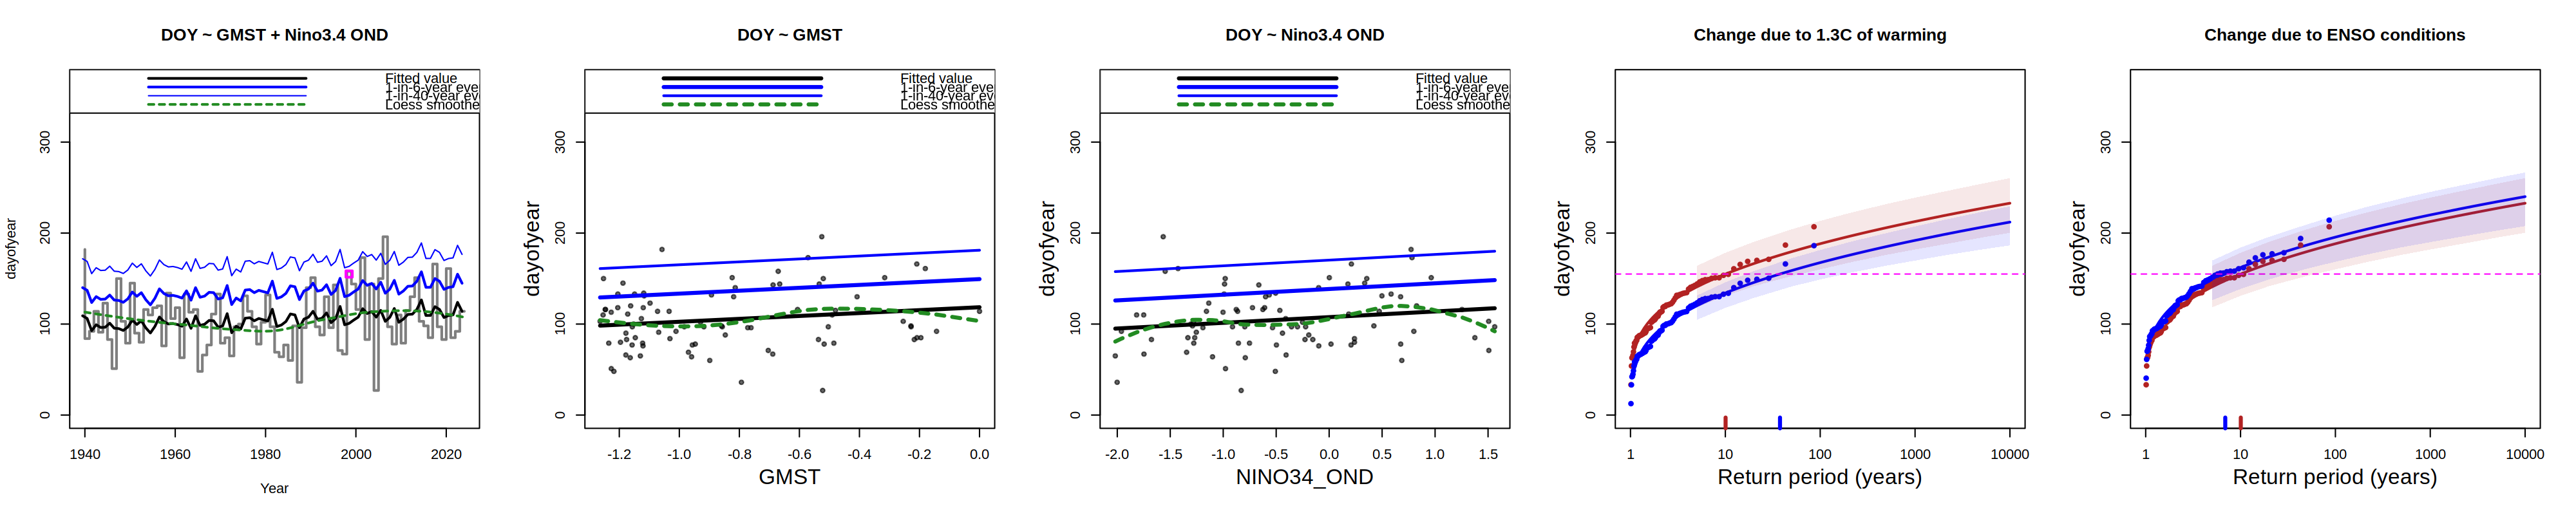

In [7]:
prep_window(c(1,5))
ylim = c(0,365)

plot_trend(mdl_doy, add_loess = T, main = "DOY ~ GMST + Nino3.4 OND", ylim = ylim)
plot_covtrend(mdl_doy, xcov = "gmst", add_loess = T, main = "DOY ~ GMST", ylim = ylim, ev_x = 999)
plot_covtrend(mdl_doy, xcov = "nino34_ond", add_loess = T, main = "DOY ~ Nino3.4 OND", ylim = ylim, ev_x = 999)

plot_returnlevels(mdl_doy, cov_f = cov_2024, cov_cf = cov_cf["pi",,drop=F], main = "Change due to 1.3C of warming", ylim = ylim)
plot_returnlevels(mdl_doy, cov_f = cov_2024, cov_cf = cov_cf["neut",,drop=F], main = "Change due to ENSO conditions", ylim = ylim)

In [9]:
boot_res <- boot_ci(mdl_doy, ev = 155, cov_f = cov_2024, cov_cf = cov_cf)
write.csv(boot_res, "res/res-obs_doy-clim30pc_era5.csv")

In [10]:
round(boot_res, 3)

,est,2.5%,97.5%
mu0,121.152,101.318,142.359
sigma0,31.974,26.512,35.829
alpha_gmst,15.972,-2.951,37.516
alpha_nino34_ond,6.250,-1.997,15.313
disp,0.281,0.220,0.335
event_magnitude,155.000,155.000,155.000
return_period,10.061,3.585,61.639
PR_pi,3.746,0.735,23.010
dI_abs_pi,20.763,-3.836,48.770
dI_rel_pi,15.468,-2.415,45.910


ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: !wget https
          ^
